In [219]:
import logging
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

<!-- # Predict Gene Expression Part II: Training and Evaluating the Model -->

<!-- This notebook uses duet evoC data to predict gene expression in mouse embryonic stem cells ES-E14. It uses methylation data in a set of genomic regions (upstream of the TSS, around TSS, gene body, first exon, first intron, exons, introns, 5 and 3' UTRs and downstream region with sense and strand information), and learns gene expression from it, using a [public dataset of expression](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE135509). The regions are based on the Gencode annotations, for the mm10 mouse genome.

For each region, we compute a mean 5mC fraction, a mean 5hmC, and record the number of CpGs in the region (regardless of whether they are methylated or not), and the length of the region. This forms a basis of 4 features per region, times 6 regions, hence 24 features.

Note that the regions we selected may have an overlap (in particular promoter, around TSS, and gene body). A natural extension would be to add more regions, mostly all exons and introns (taking the mean across them), and divide the promoter and downstream regions in sub-regions. -->

In [220]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyranges as pr
import seaborn as sns

In [290]:
from scipy.stats import spearmanr, zscore
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
    f1_score,
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [222]:
sns.set_theme()
sns.set_style("whitegrid")
biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
sns.set_palette(biomodal_palette)
column_order = [
    'before_tss', 'after_tes', 'five_prime_utrs', 'first_exons', 'first_introns', 
    'exons', 'introns', 'three_prime_utrs', 'genes',
    ]

<!-- ### Load features from pickle file -->

In [223]:
df_features = pd.read_pickle("rerun_CEGXRun1485.pickle")

<!-- ### Load Gene Expression -->

<!-- load selected transcripts -->

In [224]:
from modality.annotation import get_transcripts

def select_transcript_based_on_tag(df):
    # for each transcript in df, select the one with the highest priority tag
    # priorities are:
        # 1. 'basic,appris_principal_1,CCDS'
        # 2. 'basic,appris_principal_1'
        # 3. 'basic,CCDS'
        # 4. 'basic'
    # but with 'exp_conf' (experimentally confirmed) tag, the priority is higher.
    
    priorties = {
        'basic,appris_principal_1,exp_conf,CCDS': 1,
        'basic,appris_principal_1,CCDS': 1,
        'basic,appris_principal_1,exp_conf': 3,
        'basic,appris_principal_1': 4,
        'basic,exp_conf,CCDS': 5,
        'basic,CCDS': 6,
        'basic,exp_conf': 7,
        'basic': 8
    }

    # sort the dataframe by the priority of the tags
    df['tag_priority'] = df.tag.map(priorties)

    df = df.sort_values(by='tag_priority')

    # drop duplicates, keeping the first one
    df = df.drop_duplicates(subset='gene_id', keep='first')

    return df[["gene_id", "transcript_id"]]


# Get transcripts for mm10
transcripts = get_transcripts(
        reference="mm10",
        contig=None,
        start=None,
        end=None,
        as_pyranges=False,
    )

selected_transcripts = transcripts.groupby('gene_id').apply(
    select_transcript_based_on_tag
    ).reset_index(drop=True)
selected_transcripts.head()

gene_id          transcript_id
0   ENSMUSG00000000001.4   ENSMUST00000000001.4
1  ENSMUSG00000000003.15  ENSMUST00000000003.13
2  ENSMUSG00000000028.15  ENSMUST00000000028.13
3  ENSMUSG00000000037.17   ENSMUST00000101113.8
4  ENSMUSG00000000049.11   ENSMUST00000000049.5

<!-- function to convert tpm into rkpm -->

In [225]:
def tpm_to_rpkm(tpm, total_reads, transcript_length):
    """
    Convert TPM to RPKM.

    Parameters:
    tpm (float or array): TPM values
    total_reads (float): Total number of reads in the RNA-Seq experiment
    transcript_length (float or array): Transcript length in base pairs

    Returns:
    rpkm (float or array): RPKM values
    """
    transcript_length_kb = transcript_length / 1000  # Convert to kilobases
    rpkm = (tpm * total_reads) / transcript_length_kb
    return rpkm

In [226]:
# def rpm_to_rpkm(rpm, length):
#     """
#     Convert RPM to RPKM
#     """
#     return rpm - np.log2(length) + np.log2(1e3)

# ge_path = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135509/suppl/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
# # ge_path = "../data/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
# df_expression = pd.read_csv(ge_path, sep="\t")
# df_expression.head()

In [227]:
# def load_rna_expression(convert_to_rpkm=True):
#     rna_data_path = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135509/suppl/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
#     df_expression = pd.read_csv(rna_data_path, sep="\t")

#     # revert from log2(RPM) to RPM before taking the mean
#     df_expression["E14_rep_1"] = np.power(2, df_expression["E14_rep_1 (log2 RPM)"])
#     df_expression["E14_rep_2"] = np.power(2, df_expression["E14_rep_2 (log2 RPM)"])
#     df_expression["E14_rep_3"] = np.power(2, df_expression["E14_rep_3 (log2 RPM)"])

#     # take the mean of the three replicates
#     df_expression["E14_expr"] = np.mean(
#         df_expression[["E14_rep_1", "E14_rep_2", "E14_rep_3"]],
#         axis=1,
#     )

#     # log2 transform
#     df_expression["Response"] = np.log2(df_expression["E14_expr"])

#     # convert to RPKM
#     if convert_to_rpkm:
#         df_expression["Gene_length"] = df_expression["End"] - df_expression["Start"]
#         df_expression["Response"] = rpm_to_rpkm(
#             df_expression["Response"], df_expression["Gene_length"]
#         )

#     # Convert to 0-based
#     df_expression["Start"] = df_expression["Start"] - 1
#     df_expression["End"] = df_expression["End"] - 1

#     return df_expression

In [228]:
df_features

Gene_id Chromosome     Start       End Gene_name contig  \
0      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      1   
1      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      1   
2       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      1   
3       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      1   
4      ENSMUSG00000033813.15          1   4857813   4897908     Tcea1      1   
...                      ...        ...       ...       ...       ...    ...   
42679   ENSMUSG00000094660.2          Y  84562571  84564906   Gm21394      Y   
42680   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      Y   
42681   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      Y   
42682   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      Y   
42683   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      Y   

      strand  mean_mc_before_tss_sense  mean_mc_after_tes_sense  \
0          +                  0.000000                 0.731707   
1          -                       NaN                      NaN   
2          +                  0.000689                 0.686047   
3          -                       NaN                      NaN   
4          +                  0.001969                 0.800370   
...      ...                       ...                      ...   
42679      -                       NaN                      NaN   
42680      +                       NaN                      NaN   
42681      -                       NaN                 0.781250   
42682      +                       NaN                      NaN   
42683      -                  0.833333                 0.673913   

       mean_mc_genes_sense  ...  range_length_before_tss_sense  \
0                 0.529368  ...                          200.0   
1                 0.538405  ...                            NaN   
2                 0.472292  ...                          200.0   
3                 0.483284  ...                            NaN   
4                 0.514710  ...                          200.0   
...                    ...  ...                            ...   
42679             0.679487  ...                            NaN   
42680             0.550000  ...                            NaN   
42681             0.686275  ...                            NaN   
42682             0.721311  ...                            NaN   
42683             0.765957  ...                          200.0   

       range_length_after_tes_sense  range_length_genes_sense  \
0                            1000.0                   40622.0   
1                               NaN                   40622.0   
2                            1000.0                   78878.0   
3                               NaN                   78878.0   
4                            1000.0                   40095.0   
...                             ...                       ...   
42679                           NaN                    2335.0   
42680                           NaN                    2391.0   
42681                        1000.0                    2391.0   
42682                           NaN                   32108.0   
42683                        1000.0                   32108.0   

       range_length_first_exons_sense  range_length_first_introns_sense  \
0                               159.0                              35.0   
1                                 NaN                               NaN   
2                                90.0                           20602.0   
3                                 NaN                               NaN   
4                               162.0                            9494.0   
...                               ...                               ...   
42679                             NaN                            1114.0   
42680                             NaN                               NaN   
42681 

In [229]:
def load_rna_expression(features, selected_transcripts, transcripts):
    ge_path = "../data/quant.sf"
    df_expression = pd.read_csv(ge_path, sep="\t")
    print(df_expression.shape)

    full_selected_transcript = pd.merge(selected_transcripts,transcripts, left_on='transcript_id', right_on='id', how='left')

    # Merge df_expression with transcripts on the matching columns
    merged_df = pd.merge(full_selected_transcript[['id', 'parent', 'strand']], df_expression, left_on='id', right_on='Name', how='left')
    merged_df = pd.merge(merged_df, features[['Gene_id','contig']], left_on='parent', right_on='Gene_id', how='left')

    # Add the 'gene_id' column to df_expression
    df_expression['Gene_id'] = merged_df['parent']
    df_expression['strand'] = merged_df['strand']
    df_expression['contig'] = merged_df['contig']
    df_expression_clean = df_expression[~df_expression.isna().any(axis=1)]
    df_expression_clean

    return df_expression_clean

df_expression = load_rna_expression(df_features, selected_transcripts, transcripts)
df_expression.head()

(142699, 5)


Name  Length  EffectiveLength       TPM  NumReads  \
0  ENSMUST00000193812.1    1070          884.760  0.000000       0.0   
1  ENSMUST00000082908.1     110           10.723  0.000000       0.0   
2  ENSMUST00000162897.1    4153         3967.760  0.000000       0.0   
3  ENSMUST00000159265.1    2989         2803.760  0.088163       2.0   
4  ENSMUST00000070533.4    3634         3448.760  0.000000       0.0   

                 Gene_id strand contig  
0   ENSMUSG00000000001.4      -      3  
1   ENSMUSG00000000001.4      -      3  
2  ENSMUSG00000000003.15      -      X  
3  ENSMUSG00000000003.15      -      X  
4  ENSMUSG00000000028.15      -     16

In [230]:
df_features_expression = pd.merge(
    df_features,
    df_expression,
    on=["Gene_id", "contig", "strand"],
    how="inner",
)

In [231]:
df_features_expression

Gene_id Chromosome     Start       End Gene_name contig  \
0      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      1   
1      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      1   
2       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      1   
3       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      1   
4      ENSMUSG00000033813.15          1   4857813   4897908     Tcea1      1   
...                      ...        ...       ...       ...       ...    ...   
42027   ENSMUSG00000094660.2          Y  84562571  84564906   Gm21394      Y   
42028   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      Y   
42029   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      Y   
42030   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      Y   
42031   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      Y   

      strand  mean_mc_before_tss_sense  mean_mc_after_tes_sense  \
0          +                  0.000000                 0.731707   
1          +                  0.000000                 0.731707   
2          +                  0.000689                 0.686047   
3          +                  0.000689                 0.686047   
4          +                  0.001969                 0.800370   
...      ...                       ...                      ...   
42027      -                       NaN                      NaN   
42028      -                       NaN                 0.781250   
42029      -                       NaN                 0.781250   
42030      -                  0.833333                 0.673913   
42031      -                  0.833333                 0.673913   

       mean_mc_genes_sense  ...  range_length_exons_sense  \
0                 0.529368  ...                    2339.0   
1                 0.529368  ...                    2339.0   
2                 0.472292  ...                     725.0   
3                 0.472292  ...                     725.0   
4                 0.514710  ...                    2375.0   
...                    ...  ...                       ...   
42027             0.679487  ...                       NaN   
42028             0.686275  ...                       NaN   
42029             0.686275  ...                       NaN   
42030             0.765957  ...                     878.0   
42031             0.765957  ...                     878.0   

       range_length_introns_sense  range_length_five_prime_utrs_sense  \
0                         38089.0                                90.0   
1                         38089.0                                90.0   
2                         57461.0                                 NaN   
3                         57461.0                                 NaN   
4                         28064.0                                99.0   
...                           ...                                 ...   
42027                         NaN                                 NaN   
42028                         NaN                                 NaN   
42029                         NaN                                 NaN   
42030                     29823.0                                 NaN   
42031                     29823.0                                 NaN   

       range_length_three_prime_utrs_sense  selected_transcript  \
0                                   1722.0                 True   
1                                   1722.0                 True   
2                                      NaN                 True   
3                                      NaN                 True   
4                                   1540.0                 True   
...                                    ...                  ...   
42027                                  NaN                 True   
42028                                  NaN                 True   
42029                                  NaN

<!-- remove empty columns -->

In [232]:
nan_columns = df_features_expression.isna().all()
print(nan_columns[nan_columns].index)  # Columns with all NaN values

df_features_expression_clean = df_features_expression.dropna(axis=1, how='all')
df_features_expression_clean = df_features_expression_clean.drop('contig', axis=1)


Index(['mean_mc_before_tss_antisense', 'mean_mc_after_tes_antisense',
       'mean_mc_first_exons_antisense', 'mean_mc_first_introns_antisense',
       'mean_mc_exons_antisense', 'mean_mc_introns_antisense',
       'mean_mc_five_prime_utrs_antisense',
       'mean_mc_three_prime_utrs_antisense', 'mean_hmc_before_tss_antisense',
       'mean_hmc_after_tes_antisense', 'mean_hmc_first_exons_antisense',
       'mean_hmc_first_introns_antisense', 'mean_hmc_exons_antisense',
       'mean_hmc_introns_antisense', 'mean_hmc_five_prime_utrs_antisense',
       'mean_hmc_three_prime_utrs_antisense', 'mean_modc_before_tss_antisense',
       'mean_modc_after_tes_antisense', 'mean_modc_first_exons_antisense',
       'mean_modc_first_introns_antisense', 'mean_modc_exons_antisense',
       'mean_modc_introns_antisense', 'mean_modc_five_prime_utrs_antisense',
       'mean_modc_three_prime_utrs_antisense'],
      dtype='object')


In [233]:
df_features_expression_clean.shape

(42032, 60)

In [234]:
df_features_expression_clean.columns

Index(['Gene_id', 'Chromosome', 'Start', 'End', 'Gene_name', 'strand',
       'mean_mc_before_tss_sense', 'mean_mc_after_tes_sense',
       'mean_mc_genes_sense', 'mean_mc_first_exons_sense',
       'mean_mc_first_introns_sense', 'mean_mc_genes_antisense',
       'mean_mc_exons_sense', 'mean_mc_introns_sense',
       'mean_mc_five_prime_utrs_sense', 'mean_mc_three_prime_utrs_sense',
       'mean_hmc_before_tss_sense', 'mean_hmc_after_tes_sense',
       'mean_hmc_genes_sense', 'mean_hmc_first_exons_sense',
       'mean_hmc_first_introns_sense', 'mean_hmc_genes_antisense',
       'mean_hmc_exons_sense', 'mean_hmc_introns_sense',
       'mean_hmc_five_prime_utrs_sense', 'mean_hmc_three_prime_utrs_sense',
       'mean_modc_before_tss_sense', 'mean_modc_after_tes_sense',
       'mean_modc_genes_sense', 'mean_modc_first_exons_sense',
       'mean_modc_first_introns_sense', 'mean_modc_genes_antisense',
       'mean_modc_exons_sense', 'mean_modc_introns_sense',
       'mean_modc_five_prime_utr

<!-- Let's have a look at the data: -->

In [235]:
# add column rkpm for alternative prediction target
df_features_expression_clean["rkpm"] = df_features_expression_clean.apply(
    lambda x: tpm_to_rpkm(x['TPM'], x['NumReads'], x['EffectiveLength']),
    axis=1
)


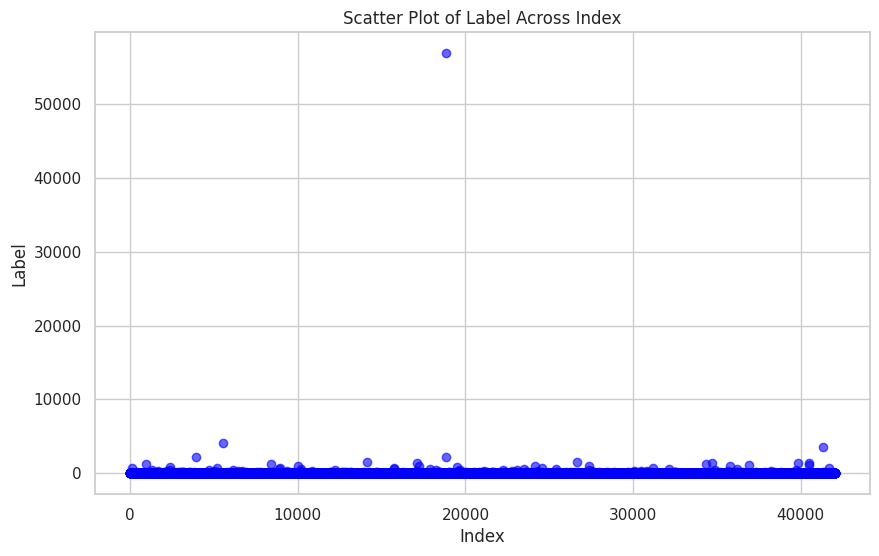

In [236]:
def plot_target(df, target):
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df[target], color='blue', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('Label')
    plt.title('Scatter Plot of Label Across Index')
    plt.show()
plot_target(df_features_expression_clean, "TPM")

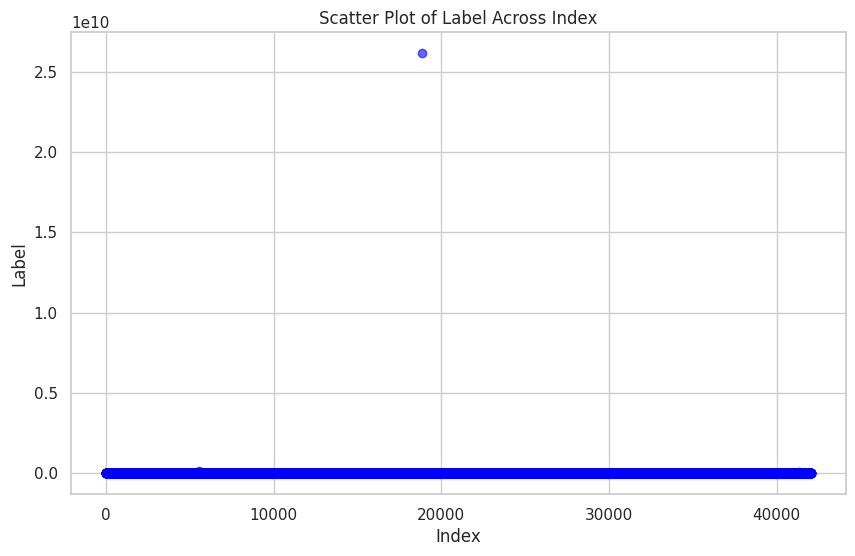

In [237]:
plot_target(df_features_expression_clean, "rkpm")

<!-- remove the outlier using z-score -->

In [238]:
not_expressed = df_features_expression_clean[df_features_expression_clean["TPM"]==0]
expressed = df_features_expression_clean[df_features_expression_clean["TPM"]>0]
not_expressed_rkpm = df_features_expression_clean[df_features_expression_clean["rkpm"]==0]
expressed_rkpm = df_features_expression_clean[df_features_expression_clean["rkpm"]>0]
print(f"tpm = 0:{not_expressed.shape}")
print(f"tpm >0 :{expressed.shape}")

print(f"rkpm =0:{not_expressed_rkpm.shape}")
print(f"rkpm >0:{expressed_rkpm.shape}")

tpm = 0:(27868, 61)
tpm >0 :(14164, 61)
rkpm =0:(27868, 61)
rkpm >0:(14164, 61)


In [293]:
def remove_outliers_target(df, target, threshold):
    # Calculate Z-scores
    z_scores = np.abs(zscore(df[target]))
    # Filter out outliers
    print(f"number of entries removed: {df[(z_scores >= threshold)].shape[0]} (out of {df.shape[0]})")
    df_clean = df[(z_scores < threshold)]
    plot_target(df_clean, target)

number of entries removed: 114 (out of 42032)


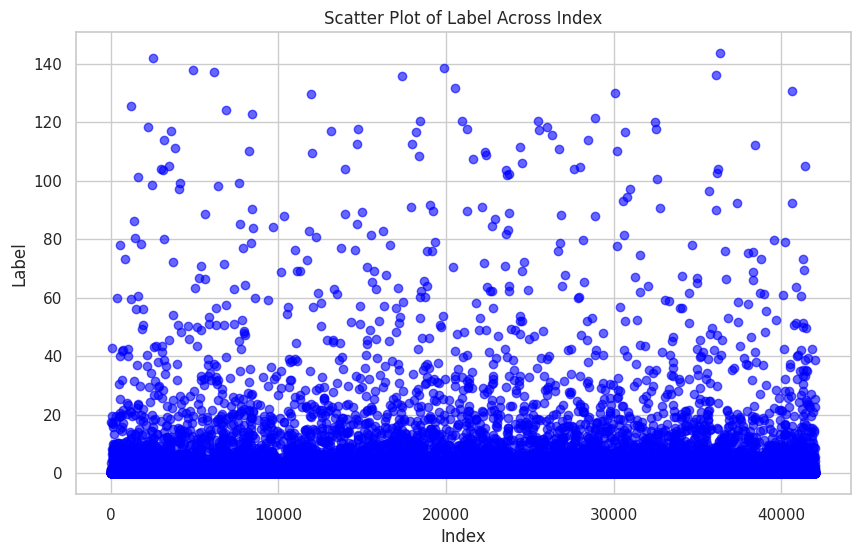

In [294]:
df_clean = remove_outliers_target(df_features_expression_clean, 'TPM', 0.5)

number of entries removed: 3 (out of 42032)


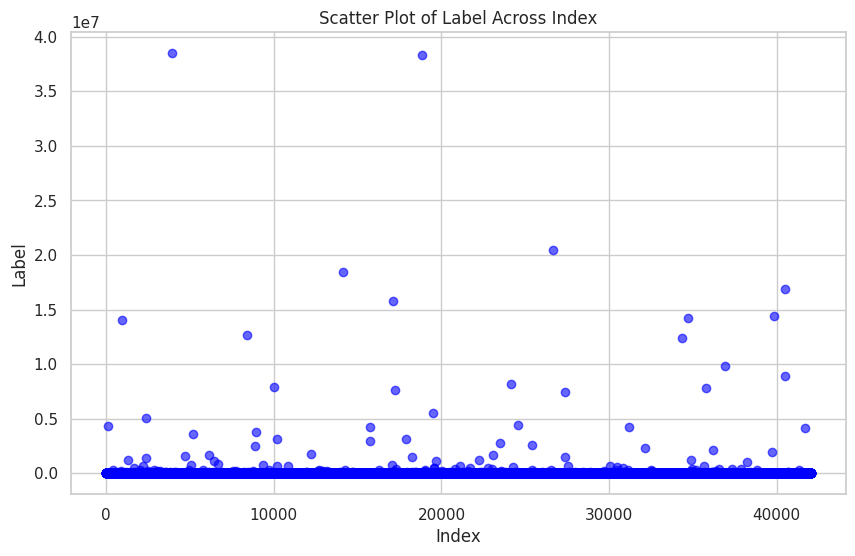

In [295]:
remove_outliers_target(df_features_expression_clean, 'rkpm', 0.5)

number of entries removed: 65 (out of 14164)


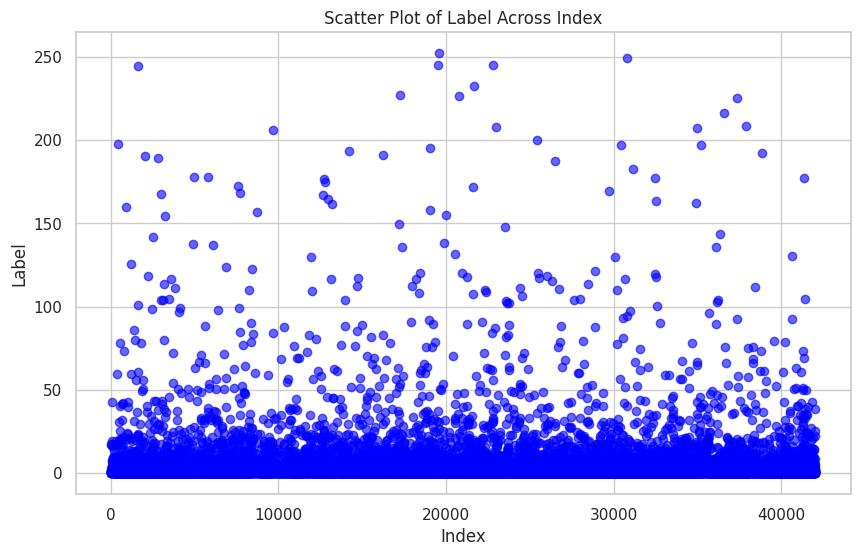

In [296]:
remove_outliers_target(expressed, 'TPM', 0.5)

number of entries removed: 2 (out of 14164)


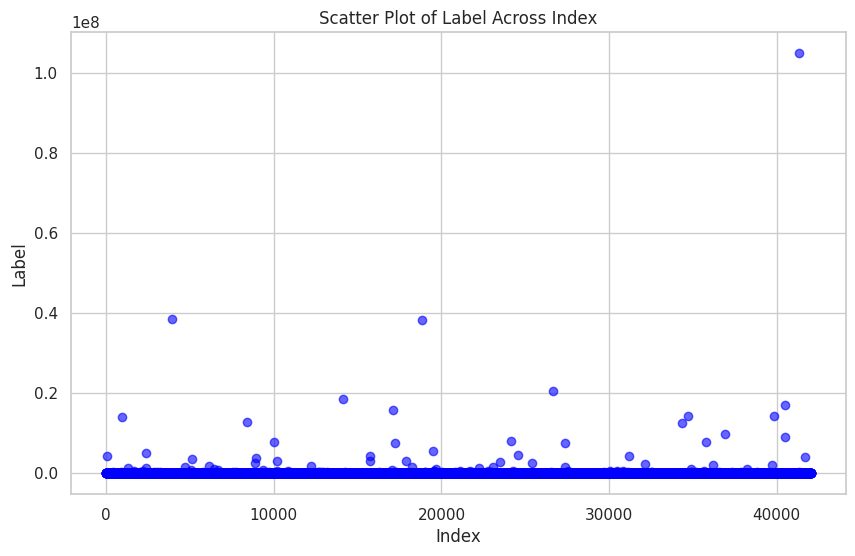

In [297]:
remove_outliers_target(expressed_rkpm, 'rkpm', 0.5)

<Axes: xlabel='TPM', ylabel='Density'>

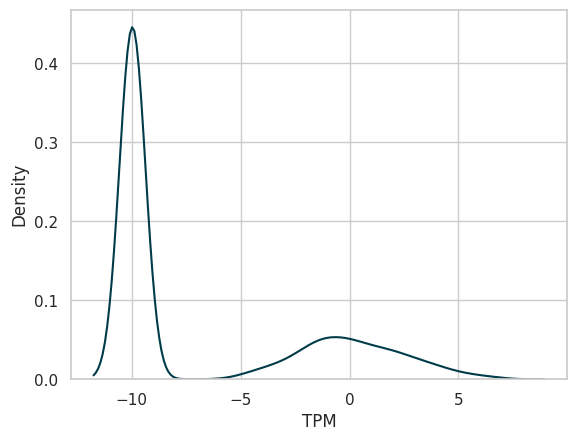

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(np.log2(df_clean["TPM"]+0.001))
# plt.xlim(0,100)  # Use parentheses to call the function

<Axes: xlabel='rkpm', ylabel='Density'>

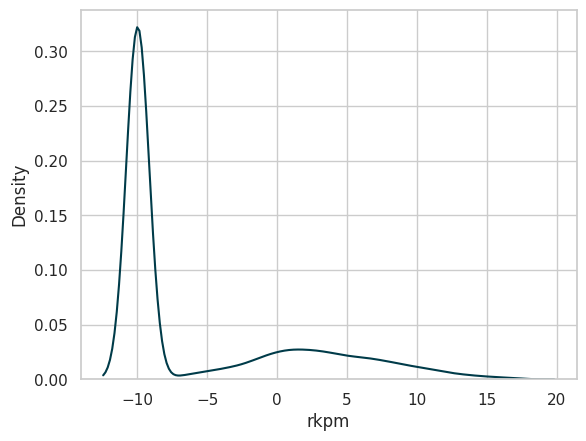

In [244]:
sns.kdeplot(np.log2(df_clean_rkpm["rkpm"]+0.001))

In [245]:
log2 = np.log2(df_clean["TPM"]+0.001)
log2[log2<-7]

0       -9.965784
1       -9.965784
4       -9.965784
9       -9.965784
10      -9.965784
           ...   
42021   -9.965784
42022   -9.965784
42025   -9.965784
42026   -9.965784
42028   -9.965784
Name: TPM, Length: 27869, dtype: float64

<!-- ## Run regressor to predict gene expression -->

<!-- We use [XGBoost](https://xgboost.readthedocs.io/en/stable/parameter.html) to train a regression model to predict RPKM gene expression values. The hyperparameters were selected from a grid search.

We split the implementation into several functions which take care of imputing missing data, split the data into testing and training, doing a grid search of hyperparameters if requested, training the model, evaluating the model, and plotting the model versus observations.

By default, we impute the mean of a feature where there is a NaN. NaNs could appear because of lack of coverage in this region. We decided on imputing a mean instead of a 0 as to not conflate the actual 0's in the features, which correspond to regions containing no methylation.

We split our data between training and testing using a leave-one-out strategy over all chromosomes. By default we use 10% of each chromosome as the test genes, and the rest of the genome for training. -->

In [246]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

def impute_multimodal(data_train, data_test, columns_to_keep, missing_values_strategy="mean"):
    print(f"inside impute -- train: {data_train.shape}, test: {data_test.shape}")

    # Subset the columns to be used
    train_subset = data_train[columns_to_keep].copy()
    test_subset = data_test[columns_to_keep].copy()

    print(f"subsets: {data_train.shape}, {data_test.shape}")

    # Apply KMeans clustering on the training data (on non-missing values)
    kmeans = KMeans(n_clusters=2, random_state=42)
    non_missing_train = train_subset.dropna()
    kmeans.fit(non_missing_train)
    # Predict clusters for the training data
    train_subset['cluster'] = kmeans.predict(train_subset.fillna(0))

    # Assign clusters to the test data based on the fitted model
    test_subset['cluster'] = kmeans.predict(test_subset.fillna(0))  # Avoid issues by filling NaNs temporarily

    print("initialised clusters")
     # Impute within each cluster for the training set
    for cluster in range(kmeans.n_clusters):
        # Train set: select rows that belong to the current cluster
        cluster_train_data = train_subset[train_subset['cluster'] == cluster]
        
        # Impute missing values for the current cluster in the training set
        imputer = SimpleImputer(strategy=missing_values_strategy)
        imputed_train = imputer.fit_transform(cluster_train_data.drop(columns='cluster'))
        train_subset.loc[train_subset['cluster'] == cluster, columns_to_keep] = imputed_train

    # Impute within each cluster for the test set
    for cluster in range(kmeans.n_clusters):
        # Test set: select rows that belong to the current cluster
        cluster_test_data = test_subset[test_subset['cluster'] == cluster]
        
        # Use the same imputer fitted on the train cluster to impute test set
        imputed_test = imputer.transform(cluster_test_data.drop(columns='cluster'))
        test_subset.loc[test_subset['cluster'] == cluster, columns_to_keep] = imputed_test

    # Drop the 'cluster' column after imputation
    train_subset = train_subset.drop(columns='cluster')
    test_subset = test_subset.drop(columns='cluster')

    # Update the original data
    data_train[columns_to_keep] = train_subset
    data_test[columns_to_keep] = test_subset

    return data_train, data_test


In [247]:
def impute_missing_values(
        data_train, 
        data_test, 
        columns_to_keep, 
        missing_values_strategy="impute_mean",
        ):
    """
    Impute missing values in a dataframe
    """
    data_train = data_train.copy()
    data_test = data_test.copy()
    if missing_values_strategy == "drop":
        data_train[columns_to_keep] = data_train[columns_to_keep].dropna()
        data_test[columns_to_keep] = data_test[columns_to_keep].dropna()
    elif missing_values_strategy == "impute_zero":
        data_train[columns_to_keep] = data_train[columns_to_keep].fillna(0)
        data_test[columns_to_keep] = data_test[columns_to_keep].fillna(0)
    elif missing_values_strategy == "impute_mean":
        imputer = SimpleImputer(strategy="mean")
        data_train_subset = imputer.fit_transform(data_train[columns_to_keep])
        data_test_subset = imputer.transform(data_test[columns_to_keep])
        # Reassign the imputed columns back into the original dataframes if needed
        print(f"train subset created: {data_train_subset.shape}")
        print(f"subset created:{data_test_subset.shape}")
        data_train[columns_to_keep] = data_train_subset
        data_test[columns_to_keep] = data_test_subset
    return data_train, data_test

In [248]:
def select_features(features, mod):
    """
    Select features based on the modification type. Only keep the features corresponding to the list `mod`. 
    E.g. if mod="modc", only keep features related to modC, and discard those related to mC and hmC
    """
    if isinstance(mod, str):
        mod = [mod]
    return [f for f in features if any([m in f for m in mod]) or (("cpg_count" in f) or ("range" in f) or ("strand" in f))]

<!-- 1. group data by chromosome
2. loop through each group, shuffle subset
3. train test split each subset with 0.1 test size, cache index of test indices identified
4. allocate test_set with collated indices
5. drop test_set indices from orginal dataset, forming train_set -->

In [249]:
from sklearn.model_selection import train_test_split
def stratified_sampling_per_contig(df, target, test_size=0.1):
    test_indices = []

    # Group by contig
    grouped = df.groupby('Chromosome')
    
    for contig, group in grouped:
        # Split the group into train and test
        # group = group.sample(frac=1, random_state=42).reset_index(drop=False)
        
        train, test = train_test_split(
            group,
            #stratify=group[target],
            test_size=test_size,
            random_state=42
        )
        
        test_indices.extend(test.index)
    
    test_set = df.loc[test_indices]
    train_set = df.drop(test_indices)
    print(f"trainset: {train_set.shape}")
    print(f"testset: {test_set.shape}")
    return train_set, test_set

In [250]:
def split_train_test_data(data, features, target, test_contig=None, missing_values_strategy="impute_mean"):
    """
    Split the data into training and testing sets using the specified test contig
    """
    print("inside train test split")
    if isinstance(test_contig, str):
        test_contig = [test_contig]
    # data_train = data[~data["Chromosome"].isin(test_contig)]
    # data_test = data[data["Chromosome"].isin(test_contig)]
    data_train , data_test = stratified_sampling_per_contig(data, target) #TODO:need to bin target to stratify

    # Check the distribution of TPM in the test set
    print(data_test[target].value_counts()/len(data))
    print('-'*50)
    # Check the distribution of contigs in the test set
    print(data_test['Chromosome'].value_counts()/data['Chromosome'].value_counts())
    print('-'*50)

    print("before imputing")

    # Assuming 'features' is your list of feature names
    impute_features = [f for f in features if not f.startswith("strand")]

    data_train, data_test = impute_multimodal(
        data_train,
        data_test,
        impute_features + [target],
        "mean"
    )
    # data_train, data_test = impute_missing_values(
    #     data_train, 
    #     data_test, 
    #     impute_features + [target], 
    #     missing_values_strategy
    #     )
    X_train, y_train = data_train[features], data_train[target]
    X_test, y_test = data_test[features], data_test[target]
    return X_train, X_test, y_train, y_test


In [251]:
def tune_parameters(X_train, y_train, model=xgb.XGBRegressor(eval_metric="rmsle"), scoring="r2"):
    """
    Identify the best hyperparameters of the XGBoost regressor using GridSearchCV
    """
    param_grid = {
        "max_depth": [5, 6, 7],
        "n_estimators": [600, 800, 1000], #[200, 300, 400, 500, 600, 700, 800],
        "subsample": [0.6, 0.7, 0.8],
        "min_child_weight": [1, 5, 10],
        "colsample_bytree": [0.8, 0.9],#[0.75, 0.8, 0.85, 0.9],
        "eta": [0.01, 0.02, 0.03]#[0.01, 0.02, 0.03, 0.04, 0.05],
    }
    
    search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, n_jobs=4).fit(X_train, y_train)
    return search.best_params_


In [252]:
def train_model(X_train, y_train, hyperparameters, random_state=1):
    """ 
    Train an XGBoost regressor using the specified hyperparameters
    """
    regressor = xgb.XGBRegressor(
        random_state=random_state,
        **hyperparameters,
    )
    regressor.fit(X_train, y_train)
    return regressor


In [253]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the performance of the model using the test set
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spear_r = spearmanr(y_test, y_pred)
    return mse, rmse, mae, r2, spear_r


In [254]:
def plot_results(y_test, y_pred, title, target):
    """
    Plot the observed vs predicted expression values for the test set
    """
    biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
    plt.plot(y_test, y_pred, ".", ms=4, c=biomodal_palette[0])
    # add x=y line
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color=biomodal_palette[2])
    plt.xlabel(f"Observed Expr. {target}")
    plt.ylabel(f"Predicted Expr. {target}")
    plt.title(title)
    plt.xlim(min(y_test)-2, max(y_test)+2)
    plt.ylim(min(y_pred)-2, max(y_pred)+2)
    plt.grid(True)
    plt.show()


In [255]:
def remove_obvious_outliers(df):
    mc_cols = [col for col in df.columns if col.startswith('mean_mc')]
    hmc_cols = [col for col in df.columns if col.startswith('mean_hmc')]
    suspicious_mc_rows = df[(df[mc_cols] == 1.0).any(axis=1)]
    suspicious_hmc_rows = df[(df[hmc_cols] == 1.0).any(axis=1)]
    # Combine the two groups to find all suspicious rows
    suspicious_rows = pd.concat([suspicious_mc_rows, suspicious_hmc_rows]).index.unique()
    print(f"rows with 1.0 mc / hmC mean meth fration: {len(suspicious_rows)}")

    # Drop the suspicious rows from the original DataFrame
    df_clean = df.drop(suspicious_rows)
    return df_clean


In [256]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def scale_counts(df,method="StandardScaler"):
    columns_to_scale = [col for col in df.columns if col.startswith("range_length") or col.startswith("cpg_count")]
    if method == "StandardScaler":
      scaler = StandardScaler()
    elif method == "MinMaxScaler":
        scaler = MinMaxScaler()
    else:
        print("not scaled!!!")
        exit=1
    # Apply the scaler on the selected columns
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    return df

def log_transform(data):
    transformed = data.copy()
    if type(data) == pd.DataFrame:
        columns_to_transform = [col for col in data.columns if col.startswith("mean_")]
        # Apply log2(x + 0.001) to the specified columns
        transformed[columns_to_transform] = data[columns_to_transform].apply(lambda x: np.log2(x + 0.001))

    elif type(data) == pd.Series:
        transformed= np.log2(data+0.001)

    return transformed





In [257]:
def preprocess(data, 
  features, 
  mod,
  target, 
  missing_values_strategy="impute_mean", 
  test_contig=None, 
):

  features = select_features(features, mod)
  print(features)

  data_cleaned = remove_obvious_outliers(data)
  print(data_cleaned.head())

  X_train, X_test, y_train, y_test = split_train_test_data(
        data_cleaned, 
        features, 
        target, 
        test_contig,
        missing_values_strategy,
        )


  print("Shape of train data")
  X_train = scale_counts(X_train,"StandardScaler")
  # X_train = log_transform(X_train)
  y_train = log_transform(y_train)
  print(X_train.shape)

  print("Shape of test data")
  X_test = scale_counts(X_test, "StandardScaler")
  # X_test = log_transform(X_test)
  y_test = log_transform(y_test)
  print(X_test.shape)


  return X_train, X_test, y_train, y_test


In [258]:
def run_regressor(
        X_train, X_test, y_train, y_test,
        hyperparameters,
        random_state=1, 
        find_optimal_parameters=False
        ):
    """
    Run the XGBoost regressor using the specified data and parameters
    """

    model = xgb.XGBRegressor(eval_metric="rmsle")
    scoring="r2"
  
    if find_optimal_parameters:
                best_params = tune_parameters(X_train, y_train, model, scoring)
                hyperparameters.update(best_params)

    print("Using params")
    print(hyperparameters)
    

    model = train_model(X_train, y_train, hyperparameters, random_state)

    mse, rmse, mae, r2, spear_r = evaluate_model(model, X_test, y_test)

    df_metrics = pd.DataFrame({
        "mse": [mse],
        "rmse": [rmse],
        "mae": [mae],
        "r2": [r2],
        "spearman": [spear_r[0]],
    })

    y_pred = model.predict(X_test)

    return model, df_metrics, y_test, y_pred


In [259]:
def run_regressor_orig(
        data, 
        features, 
        mod,
        target, 
        hyperparameters,
        random_state=1, 
        missing_values_strategy="impute_mean", 
        test_contig=None, 
        find_optimal_parameters=False
        ):
    """
    Run the XGBoost regressor using the specified data and parameters
    """

    features = select_features(features, mod)
    
    X_train, X_test, y_train, y_test = split_train_test_data(
        data, 
        features, 
        target, 
        test_contig,
        missing_values_strategy,
        )

    if find_optimal_parameters:
        best_params = tune_parameters(X_train, y_train)
        hyperparameters.update(best_params)

    model = train_model(X_train, y_train, hyperparameters, random_state)

    mse, rmse, mae, r2, spear_r = evaluate_model(model, X_test, y_test)

    df_metrics = pd.DataFrame({
        "mse": [mse],
        "rmse": [rmse],
        "mae": [mae],
        "r2": [r2],
        "spearman": [spear_r[0]],
    })

    y_pred = model.predict(X_test)

    return model, df_metrics, y_test, y_pred


<!-- ### Run the model -->

<!-- Let's run the model in the case where we want to train a gene expression predictor using mC and hmC methylation levels. -->

In [260]:
# target = 'TPM'
target = "rkpm"

In [261]:
df_clean


Gene_id Chromosome     Start       End Gene_name strand  \
0      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      +   
1      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1      +   
2       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      +   
3       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988      +   
4      ENSMUSG00000033813.15          1   4857813   4897908     Tcea1      +   
...                      ...        ...       ...       ...       ...    ...   
42027   ENSMUSG00000094660.2          Y  84562571  84564906   Gm21394      -   
42028   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      -   
42029   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854      -   
42030   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      -   
42031   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996      -   

       mean_mc_before_tss_sense  mean_mc_after_tes_sense  mean_mc_genes_sense  \
0                      0.000000                 0.731707             0.529368   
1                      0.000000                 0.731707             0.529368   
2                      0.000689                 0.686047             0.472292   
3                      0.000689                 0.686047             0.472292   
4                      0.001969                 0.800370             0.514710   
...                         ...                      ...                  ...   
42027                       NaN                      NaN             0.679487   
42028                       NaN                 0.781250             0.686275   
42029                       NaN                 0.781250             0.686275   
42030                  0.833333                 0.673913             0.765957   
42031                  0.833333                 0.673913             0.765957   

       mean_mc_first_exons_sense  ...  range_length_introns_sense  \
0                       0.000471  ...                     38089.0   
1                       0.000471  ...                     38089.0   
2                       0.000000  ...                     57461.0   
3                       0.000000  ...                     57461.0   
4                       0.000917  ...                     28064.0   
...                          ...  ...                         ...   
42027                        NaN  ...                         NaN   
42028                        NaN  ...                         NaN   
42029                        NaN  ...                         NaN   
42030                        NaN  ...                     29823.0   
42031                        NaN  ...                     29823.0   

       range_length_five_prime_utrs_sense  \
0                                    90.0   
1                                    90.0   
2                                     NaN   
3                                     NaN   
4                                    99.0   
...                                   ...   
42027                                 NaN   
42028                                 NaN   
42029                                 NaN   
42030                                 NaN   
42031                                 NaN   

       range_length_three_prime_utrs_sense  selected_transcript  \
0                                   1722.0                 True   
1                                   1722.0                 True   
2                                      NaN                 True   
3                                      NaN                 True   
4                                   1540.0                 True   
...                                    ...                  ...   
42027                                  NaN                 True   
42028                                  NaN                 True   
42029                                  NaN                 True   
42030                                203.0     

In [262]:
# default_hyperparameters = {
#     'n_estimators': 500, 
#     'max_depth': 6, 
#     'colsample_bytree': 0.85, 
#     'eta': 0.02, 
#     'subsample': 0.6,
#     }

default_hyperparameters = {
    'n_estimators': 600, 
    'colsample_bytree': 0.8, 
    'eta': 0.01, 
    'max_depth': 5, 
    'min_child_weight': 10, 
    'subsample': 0.8
}

In [263]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# 0 = +, 1 = -
df_clean['strand'] = le.fit_transform(df_clean['strand'])
df_clean

Gene_id Chromosome     Start       End Gene_name  strand  \
0      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1       0   
1      ENSMUSG00000025903.14          1   4807787   4848409    Lypla1       0   
2       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988       0   
3       ENSMUSG00000104217.1          1   4807891   4886769   Gm37988       0   
4      ENSMUSG00000033813.15          1   4857813   4897908     Tcea1       0   
...                      ...        ...       ...       ...       ...     ...   
42027   ENSMUSG00000094660.2          Y  84562571  84564906   Gm21394       1   
42028   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854       1   
42029   ENSMUSG00000095650.2          Y  85528516  85530907   Gm20854       1   
42030   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996       1   
42031   ENSMUSG00000100608.1          Y  89713423  89745531   Gm21996       1   

       mean_mc_before_tss_sense  mean_mc_after_tes_sense  mean_mc_genes_sense  \
0                      0.000000                 0.731707             0.529368   
1                      0.000000                 0.731707             0.529368   
2                      0.000689                 0.686047             0.472292   
3                      0.000689                 0.686047             0.472292   
4                      0.001969                 0.800370             0.514710   
...                         ...                      ...                  ...   
42027                       NaN                      NaN             0.679487   
42028                       NaN                 0.781250             0.686275   
42029                       NaN                 0.781250             0.686275   
42030                  0.833333                 0.673913             0.765957   
42031                  0.833333                 0.673913             0.765957   

       mean_mc_first_exons_sense  ...  range_length_introns_sense  \
0                       0.000471  ...                     38089.0   
1                       0.000471  ...                     38089.0   
2                       0.000000  ...                     57461.0   
3                       0.000000  ...                     57461.0   
4                       0.000917  ...                     28064.0   
...                          ...  ...                         ...   
42027                        NaN  ...                         NaN   
42028                        NaN  ...                         NaN   
42029                        NaN  ...                         NaN   
42030                        NaN  ...                     29823.0   
42031                        NaN  ...                     29823.0   

       range_length_five_prime_utrs_sense  \
0                                    90.0   
1                                    90.0   
2                                     NaN   
3                                     NaN   
4                                    99.0   
...                                   ...   
42027                                 NaN   
42028                                 NaN   
42029                                 NaN   
42030                                 NaN   
42031                                 NaN   

       range_length_three_prime_utrs_sense  selected_transcript  \
0                                   1722.0                 True   
1                                   1722.0                 True   
2                                      NaN                 True   
3                                      NaN                 True   
4                                   1540.0                 True   
...                                    ...                  ...   
42027                                  NaN                 True   
42028                                  NaN                 True   
42029                                  NaN                 True   
42030                              

In [264]:
nan_columns = df_clean.isna().all()
print(nan_columns[nan_columns].index)  # Columns with all NaN values


Index([], dtype='object')


<!-- dropping fixed range length as it's constant across dataset -->

In [265]:
df_clean['range_length_before_tss_sense'].unique()

array([200.,  nan])

In [266]:
#pre train-test-split pre-processing
df_clean = df_clean.drop(['range_length_before_tss_sense', 'range_length_after_tes_sense'], axis=1)

# df_dropped data for viewing
df_dropped = remove_obvious_outliers(df_clean)
features_tmp = [
    c for c in df_dropped.columns if
        (c.startswith("mean")
        or c.startswith("cpg_count")
        or c.startswith("range")
        or c.startswith("strand"))
    ]
print(f"features: {len(features_tmp)}")

# df_dropped = minmax_scaler(df_dropped[features_tmp+["TPM"]])
df_dropped = scale_counts(df_dropped[features_tmp+[target]],"StandardScaler")

rows with 1.0 mc / hmC mean meth fration: 6
features: 47


In [267]:
df_dropped['range_length_exons_sense']

0       -0.220022
1       -0.220022
2       -0.875363
3       -0.875363
4       -0.205405
           ...   
42027         NaN
42028         NaN
42029         NaN
42030   -0.813239
42031   -0.813239
Name: range_length_exons_sense, Length: 41912, dtype: float64

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_numeric_features_grid(df, target, num_cols=4):
    # List of features to plot
    features = [col for col in df.columns if col != target and col != "strand"]
    num_features = len(features)
    print(f"number of features: {num_features}")
    
    # Calculate number of rows needed for the grid
    num_rows = int(np.ceil(num_features / num_cols))
    
    # Create subplots with grid layout
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 5, num_rows * 4))
    
    # Flatten axes array if needed
    axes = axes.flatten() if num_features > 1 else [axes]
    
    # Plot each feature against the target
    for i, feature in enumerate(features):
        sns.scatterplot(data=df, x=feature, y=target, ax=axes[i])
        axes[i].set_title(f'{feature} vs Target')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Target')
    
    # Hide any unused subplots
    for ax in axes[num_features:]:
        ax.axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [269]:
def plot_numeric_features_histogram_grid(df, target, num_cols=4):
    # List of numeric features to plot
    # features = [col for col in df.columns if df[col].dtype != 'object']
    features = [col for col in df.columns if col != target and col != "strand"]
    num_features = len(features)
    print(f"number of features: {num_features}")

    
    # Calculate number of rows needed for the grid
    num_rows = int(np.ceil(num_features / num_cols))
    
    # Create subplots with grid layout
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 5, num_rows * 4))
    
    # Flatten axes array if needed
    axes = axes.flatten() if num_features > 1 else [axes]
    
    # Plot histograms for each feature
    for i, feature in enumerate(features):
        sns.histplot(data=df, x=feature, ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')
    
    # Hide any unused subplots
    for ax in axes[num_features:]:
        ax.axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [270]:
df_dropped[df_dropped['mean_mc_after_tes_sense'] == 1.0]

Empty DataFrame
Columns: [strand, mean_mc_before_tss_sense, mean_mc_after_tes_sense, mean_mc_genes_sense, mean_mc_first_exons_sense, mean_mc_first_introns_sense, mean_mc_genes_antisense, mean_mc_exons_sense, mean_mc_introns_sense, mean_mc_five_prime_utrs_sense, mean_mc_three_prime_utrs_sense, mean_hmc_before_tss_sense, mean_hmc_after_tes_sense, mean_hmc_genes_sense, mean_hmc_first_exons_sense, mean_hmc_first_introns_sense, mean_hmc_genes_antisense, mean_hmc_exons_sense, mean_hmc_introns_sense, mean_hmc_five_prime_utrs_sense, mean_hmc_three_prime_utrs_sense, mean_modc_before_tss_sense, mean_modc_after_tes_sense, mean_modc_genes_sense, mean_modc_first_exons_sense, mean_modc_first_introns_sense, mean_modc_genes_antisense, mean_modc_exons_sense, mean_modc_introns_sense, mean_modc_five_prime_utrs_sense, mean_modc_three_prime_utrs_sense, cpg_count_before_tss_sense, cpg_count_after_tes_sense, cpg_count_genes_sense, cpg_count_first_exons_sense, cpg_count_first_introns_sense, cpg_count_exons_sense, cpg_count_introns_sense, cpg_count_five_prime_utrs_sense, cpg_count_three_prime_utrs_sense, range_length_genes_sense, range_length_first_exons_sense, range_length_first_introns_sense, range_length_exons_sense, range_length_introns_sense, range_length_five_prime_utrs_sense, range_length_three_prime_utrs_sense, rkpm]
Index: []

[0 rows x 48 columns]

In [271]:
df_dropped

strand  mean_mc_before_tss_sense  mean_mc_after_tes_sense  \
0           0                  0.000000                 0.731707   
1           0                  0.000000                 0.731707   
2           0                  0.000689                 0.686047   
3           0                  0.000689                 0.686047   
4           0                  0.001969                 0.800370   
...       ...                       ...                      ...   
42027       1                       NaN                      NaN   
42028       1                       NaN                 0.781250   
42029       1                       NaN                 0.781250   
42030       1                  0.833333                 0.673913   
42031       1                  0.833333                 0.673913   

       mean_mc_genes_sense  mean_mc_first_exons_sense  \
0                 0.529368                   0.000471   
1                 0.529368                   0.000471   
2                 0.472292                   0.000000   
3                 0.472292                   0.000000   
4                 0.514710                   0.000917   
...                    ...                        ...   
42027             0.679487                        NaN   
42028             0.686275                        NaN   
42029             0.686275                        NaN   
42030             0.765957                        NaN   
42031             0.765957                        NaN   

       mean_mc_first_introns_sense  mean_mc_genes_antisense  \
0                         0.001631                 0.529368   
1                         0.001631                 0.529368   
2                         0.465331                 0.472292   
3                         0.465331                 0.472292   
4                         0.288788                 0.514710   
...                            ...                      ...   
42027                     0.679487                 0.679487   
42028                     0.686275                 0.686275   
42029                     0.686275                 0.686275   
42030                     0.923077                 0.765957   
42031                     0.923077                 0.765957   

       mean_mc_exons_sense  mean_mc_introns_sense  \
0                 0.708118               0.556417   
1                 0.708118               0.556417   
2                 0.788673               0.479122   
3                 0.788673               0.479122   
4                 0.783244               0.684962   
...                    ...                    ...   
42027                  NaN                    NaN   
42028                  NaN                    NaN   
42029                  NaN                    NaN   
42030             0.806452               0.756987   
42031             0.806452               0.756987   

       mean_mc_five_prime_utrs_sense  ...  cpg_count_five_prime_utrs_sense  \
0                           0.000863  ...                        -0.186736   
1                           0.000863  ...                        -0.186736   
2                                NaN  ...                              NaN   
3                                NaN  ...                              NaN   
4                           0.001152  ...                        -0.245875   
...                              ...  ...                              ...   
42027                            NaN  ...                              NaN   
42028                            NaN  ...                              NaN   
42029                            NaN  ...                              NaN   
42030                            NaN  ...                              NaN   
42031                            NaN  ...                              NaN   

       cpg_count_three_prime_utrs_sense  range_length_genes_sense  \
0                             -0.252471                 -0.085133   
1                             -0.252

plot histogram

In [272]:
# plot_numeric_features_histogram_grid(df_dropped, target)

In [273]:
# plot_numeric_features_histogram_grid(df_dropped, 'TPM')

In [50]:
# extreme_cols_to_drop = [
#     "mean_mc_before_tss_sense",
#     "mean_hmc_before_tss_sense",
#     "mean_modc_before_tss_sense",

#     "mean_mc_after_tes_sense",
#     "mean_hmc_after_tes_sense",
#     "mean_modc_after_tes_sense",

#     "mean_mc_first_exons_sense",
#     "mean_hmc_first_exons_sense",
#     "mean_modc_first_exons_sense",

#     "mean_mc_first_introns_sense",
#     "mean_hmc_first_introns_sense",
#     "mean_modc_first_introns_sense",

#     "mean_mc_five_prime_utrs_sense",
#     "mean_hmc_five_prime_utrs_sense",
#     "mean_modc_five_prime_utrs_sense"
# ]

In [278]:
# df_dropped_extreme = df_dropped.drop(extreme_cols_to_drop, axis=1)
# # plot_numeric_features_histogram_grid(df_dropped_extreme,"TPM")

number of features: 46


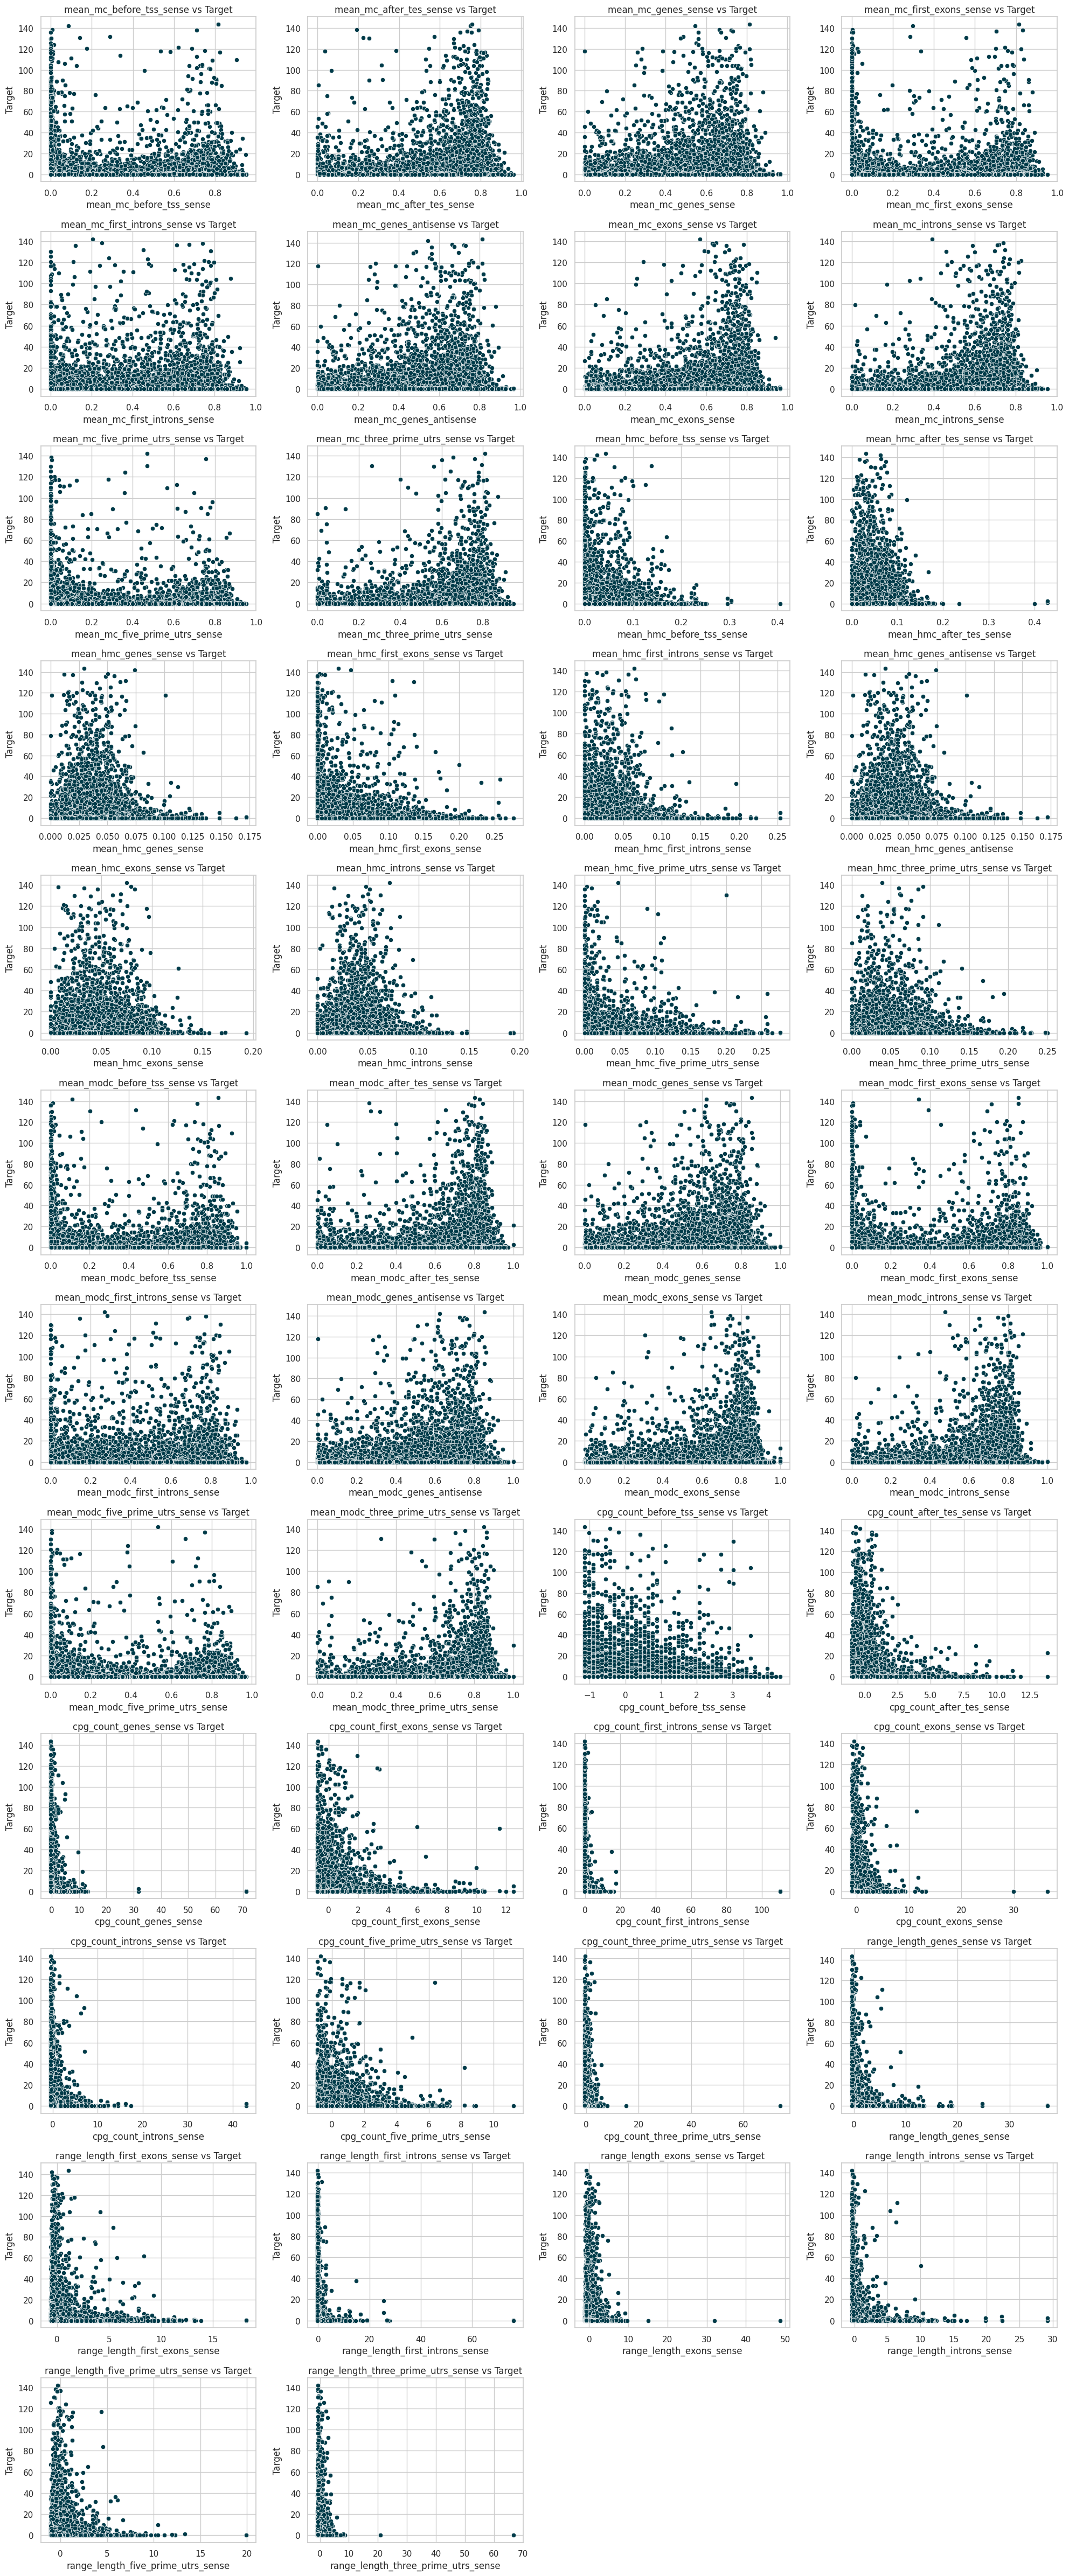

In [52]:
# plot_numeric_features_grid(df_dropped,'TPM')

In [53]:
# plot_numeric_features_grid(df,'TPM')

In [280]:
features = [
    c for c in df_clean.columns if
        (c.startswith("mean")
        or c.startswith("cpg_count")
        or c.startswith("range")
        or c.startswith("strand"))
    ]

In [281]:
# df_use = df_clean.copy()
## parse data=df_use[remain_cols], features=remain_cols into prepricess()
# remain_cols = [f for f in df_use.columns if f not in extreme_cols_to_drop]
# remain_feat = [ f for f in features if f not in extreme_cols_to_drop]

X_train, X_test, y_train, y_test = preprocess(
    data=df_clean,
    features=features,
    mod = ["mc", "hmc"],
    target=target,
    # test_contig=["8"],
    missing_values_strategy="impute_mean",
    # missing_values_strategy="impute_zero"
)

['strand', 'mean_mc_before_tss_sense', 'mean_mc_after_tes_sense', 'mean_mc_genes_sense', 'mean_mc_first_exons_sense', 'mean_mc_first_introns_sense', 'mean_mc_genes_antisense', 'mean_mc_exons_sense', 'mean_mc_introns_sense', 'mean_mc_five_prime_utrs_sense', 'mean_mc_three_prime_utrs_sense', 'mean_hmc_before_tss_sense', 'mean_hmc_after_tes_sense', 'mean_hmc_genes_sense', 'mean_hmc_first_exons_sense', 'mean_hmc_first_introns_sense', 'mean_hmc_genes_antisense', 'mean_hmc_exons_sense', 'mean_hmc_introns_sense', 'mean_hmc_five_prime_utrs_sense', 'mean_hmc_three_prime_utrs_sense', 'cpg_count_before_tss_sense', 'cpg_count_after_tes_sense', 'cpg_count_genes_sense', 'cpg_count_first_exons_sense', 'cpg_count_first_introns_sense', 'cpg_count_exons_sense', 'cpg_count_introns_sense', 'cpg_count_five_prime_utrs_sense', 'cpg_count_three_prime_utrs_sense', 'range_length_genes_sense', 'range_length_first_exons_sense', 'range_length_first_introns_sense', 'range_length_exons_sense', 'range_length_introns_

In [282]:
train_full = pd.concat([X_train, y_train])
test_full = pd.concat([X_test, y_test])

In [283]:
# Compute the correlation matrix
corr_matrix = X_train.corr()

# Get the absolute values of the correlation matrix
corr_matrix_abs = corr_matrix.abs()

# Mask the upper triangle of the matrix (to remove mirrored pairs)
mask = np.triu(np.ones_like(corr_matrix_abs, dtype=bool))

# Apply the mask to the correlation matrix
reduced_corr_matrix = corr_matrix_abs.mask(mask)

# Unstack the matrix and drop NaN values (resulting from the mask)
corr_pairs = reduced_corr_matrix.unstack().dropna()

# Filter the pairs with a correlation higher than 0.5
high_corr_pairs = corr_pairs[corr_pairs > 0.5]

# Sort the pairs by correlation value
high_corr_pairs_sorted = high_corr_pairs.sort_values(ascending=False)

# Display the unique pairs with correlation higher than 0.5
print(high_corr_pairs_sorted)
print(f"{len(high_corr_pairs)} / {len(corr_pairs)}")



mean_hmc_genes_sense              mean_hmc_genes_antisense               1.000000
mean_mc_genes_sense               mean_mc_genes_antisense                1.000000
cpg_count_introns_sense           range_length_introns_sense             0.911456
cpg_count_first_introns_sense     range_length_first_introns_sense       0.892411
cpg_count_genes_sense             range_length_genes_sense               0.884422
range_length_genes_sense          range_length_introns_sense             0.884013
cpg_count_three_prime_utrs_sense  range_length_three_prime_utrs_sense    0.881213
cpg_count_introns_sense           range_length_genes_sense               0.808741
cpg_count_genes_sense             cpg_count_introns_sense                0.779249
mean_hmc_first_exons_sense        mean_hmc_five_prime_utrs_sense         0.764105
cpg_count_exons_sense             range_length_exons_sense               0.736944
cpg_count_genes_sense             cpg_count_first_introns_sense          0.724345
                

number of features: 36


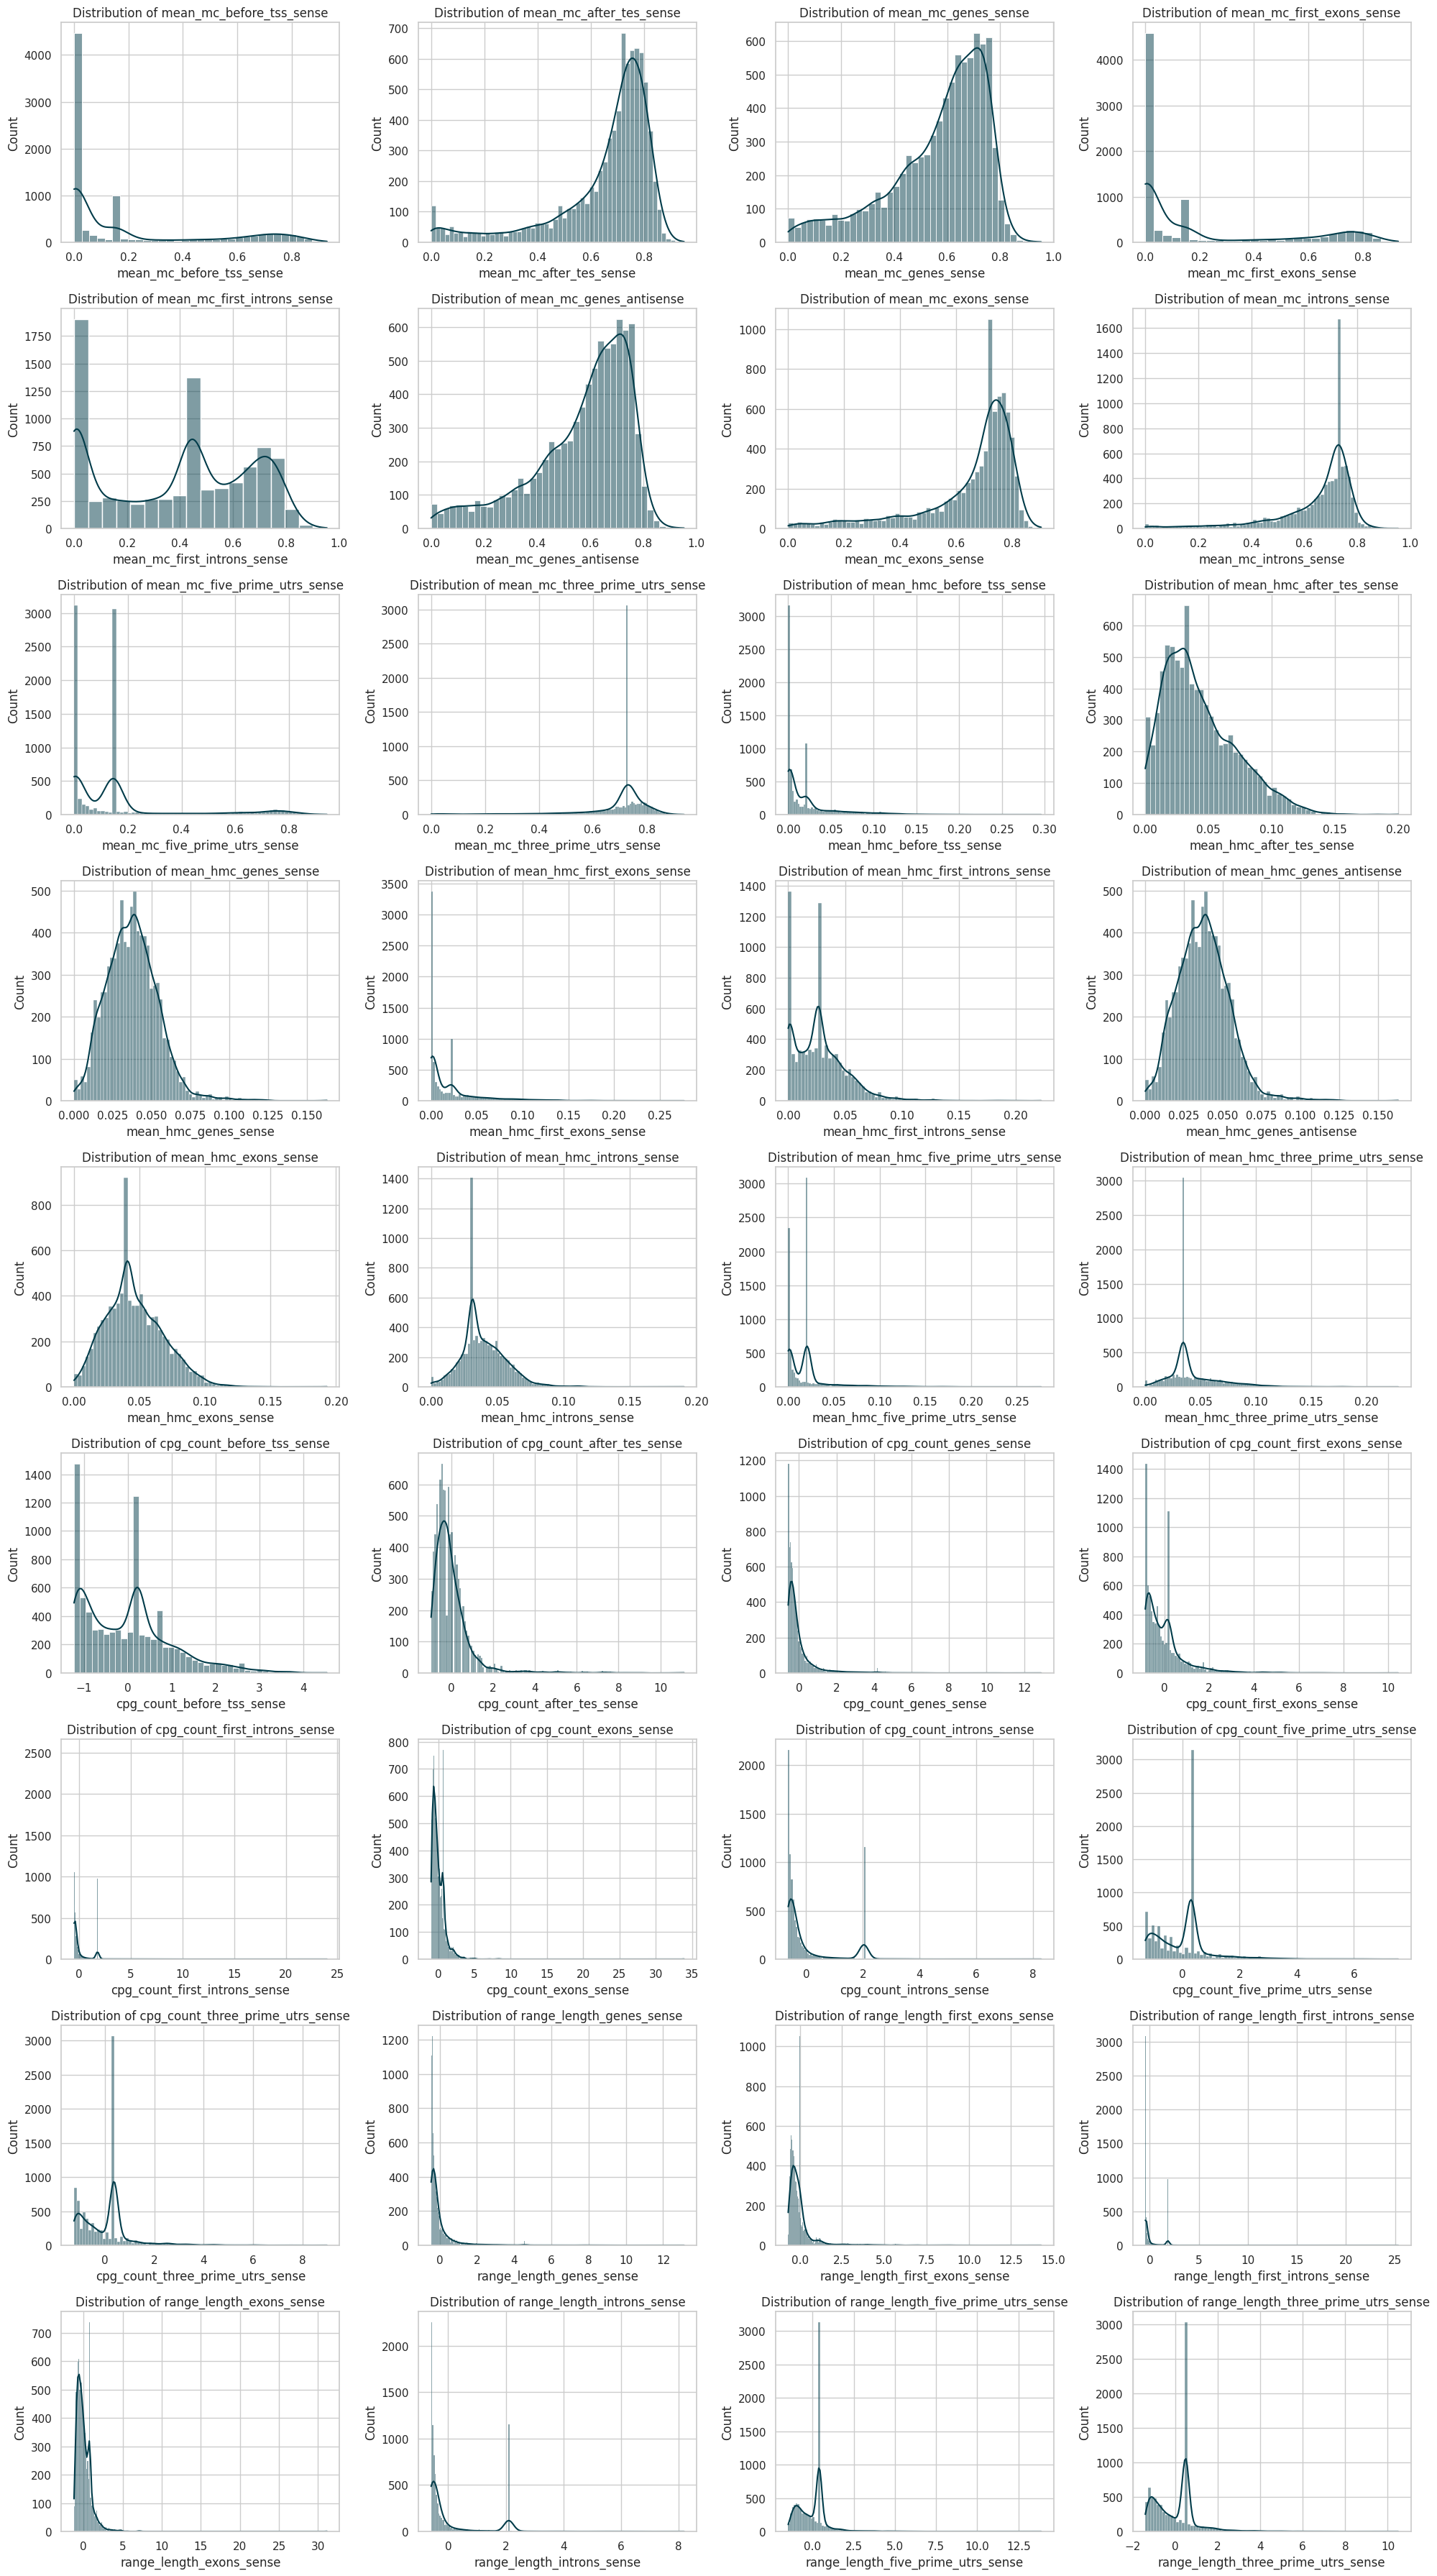

In [140]:
# plot_numeric_features_histogram_grid(test_full, 'TPM')

number of features: 46


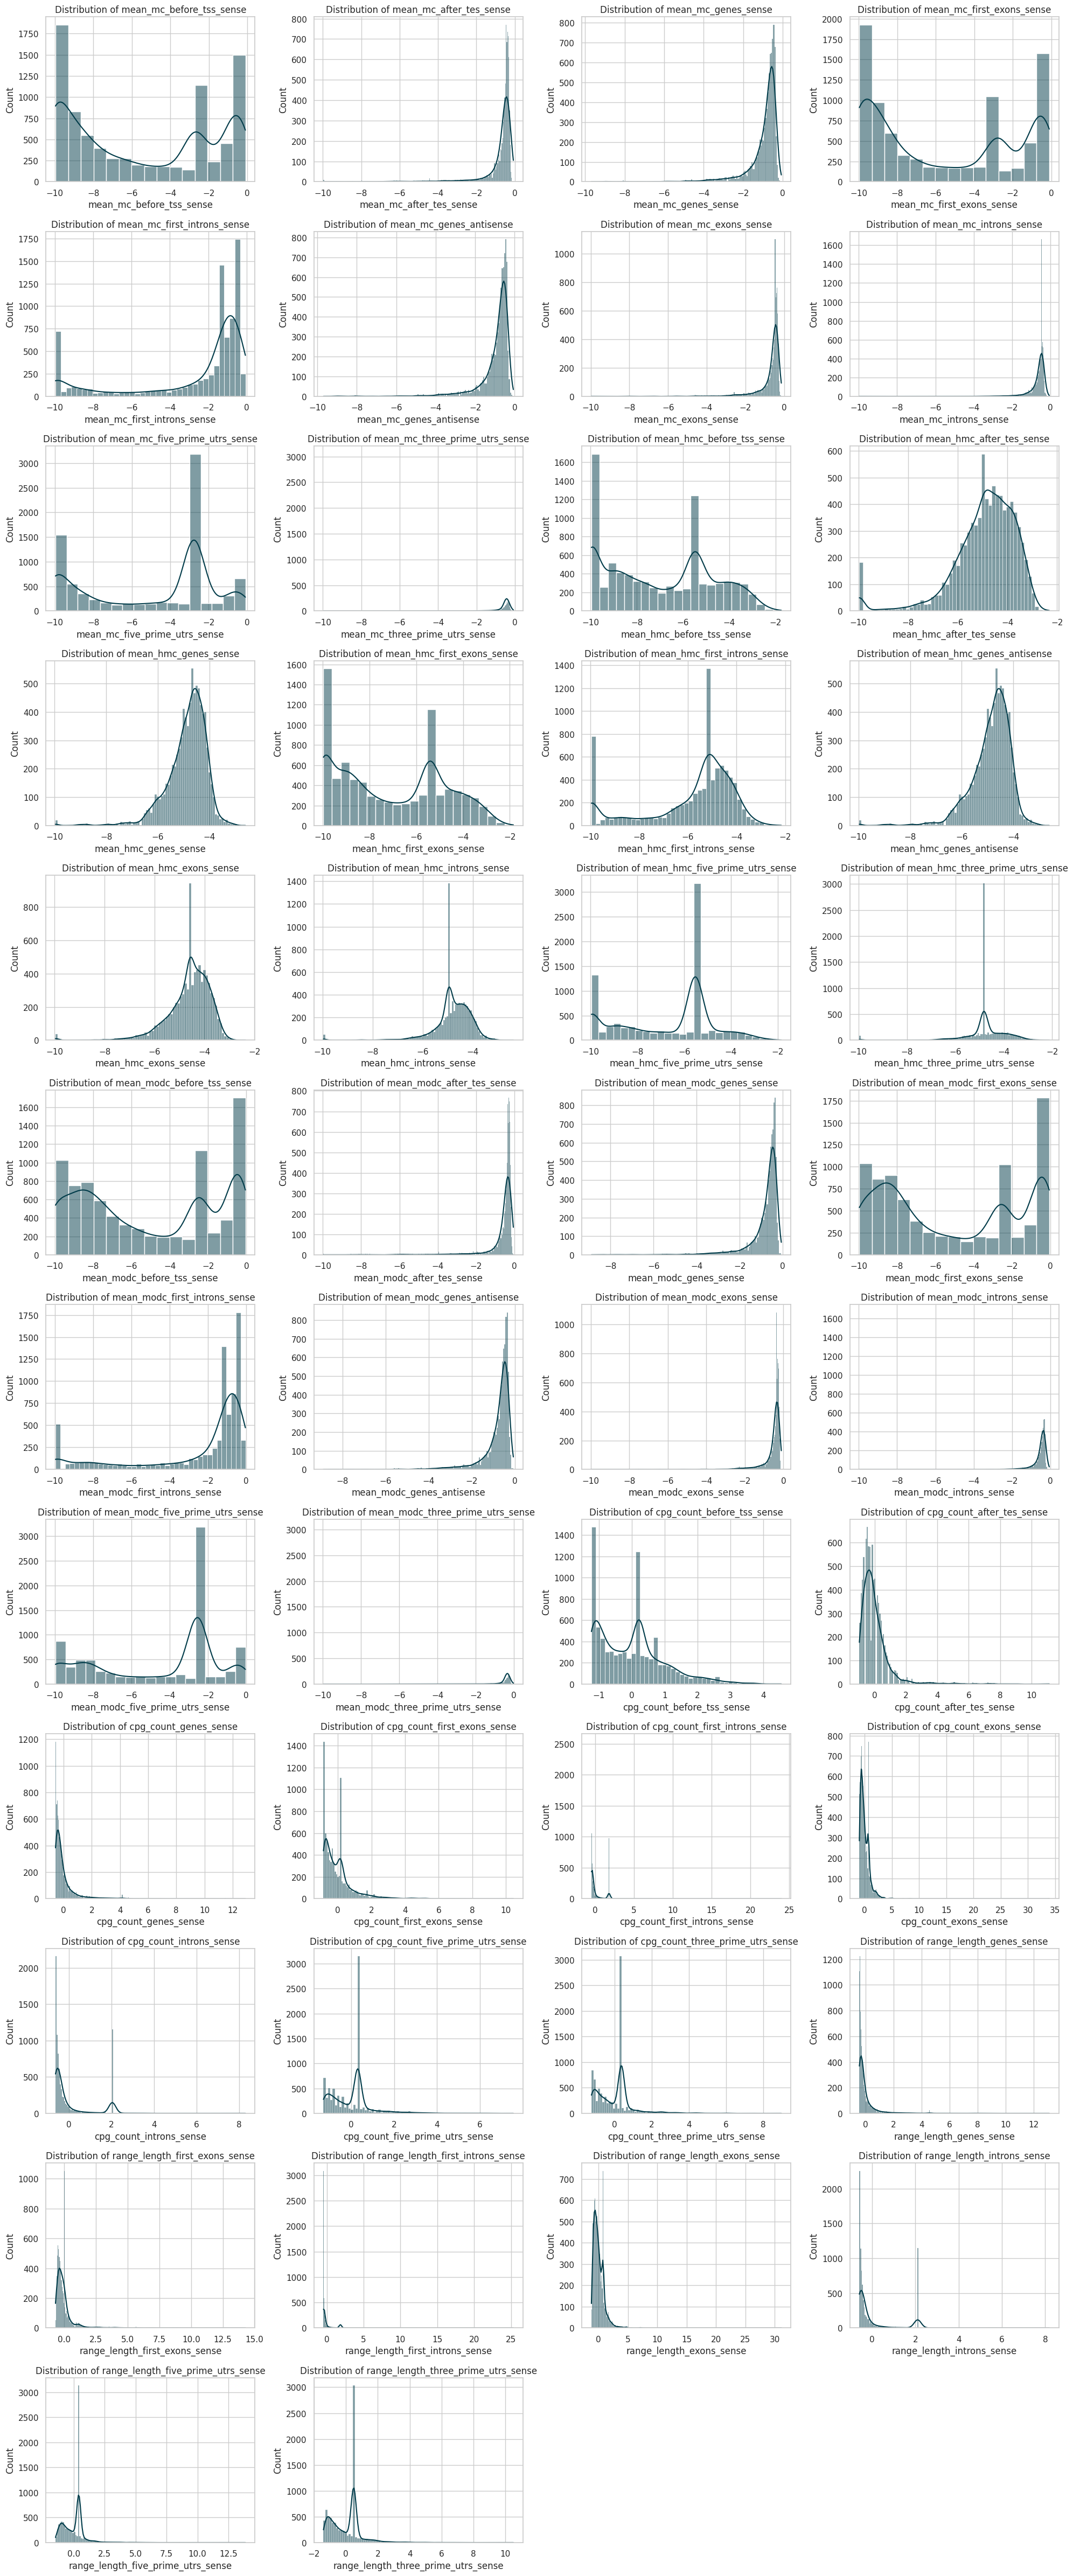

In [63]:
# plot_numeric_features_histogram_grid(test_full, 'TPM')


In [53]:
# plot_numeric_features_histogram_grid(train_full, 'TPM')

using all features (code expired):

In [61]:
# model, df_metrics, y_test, y_pred = run_regressor(
#     X_train, X_test, y_train, y_test,
#     hyperparameters=default_hyperparameters,
#     random_state=0,
#     find_optimal_parameters=True,
# )    


USing params
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 600, 'subsample': 0.8}


In [63]:
# df_metrics

mse       rmse       mae        r2  spearman
0  197.719186  14.061265  4.027517 -0.043226  0.028218

In [279]:
# plot_results(
#     y_test, 
#     y_pred, 
#     f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
# )

using dropped extreme features

In [51]:
# model, df_metrics, y_test, y_pred = run_regressor(
#     X_train, X_test, y_train, y_test,
#     hyperparameters=default_hyperparameters,
#     random_state=0,
#     find_optimal_parameters=True,
# )    

USing params
{'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 600, 'subsample': 0.7}


In [52]:
# df_metrics

mse       rmse       mae        r2  spearman
0  309.777767  17.600505  4.612455 -0.043699  0.008379

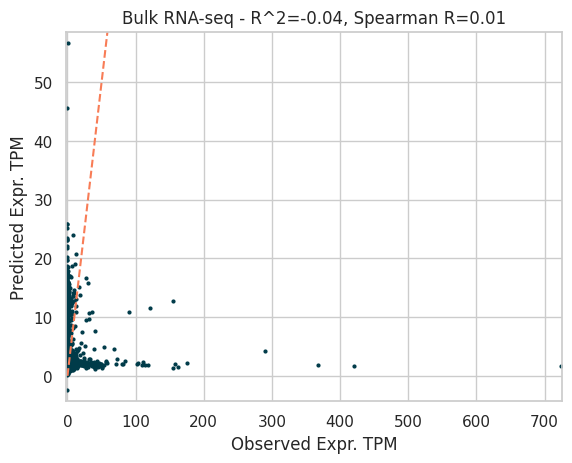

In [53]:
# plot_results(
#     y_test, 
#     y_pred, 
#     f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
# )

log_transformed data, impute nans with kmeans (n_cluster = 2)

In [128]:
# model, df_metrics, y_test, y_pred = run_regressor(
#     X_train, X_test, y_train, y_test,
#     hyperparameters=default_hyperparameters,
#     random_state=0,
#     find_optimal_parameters=False,
# )  

Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}


In [68]:
# df_metrics

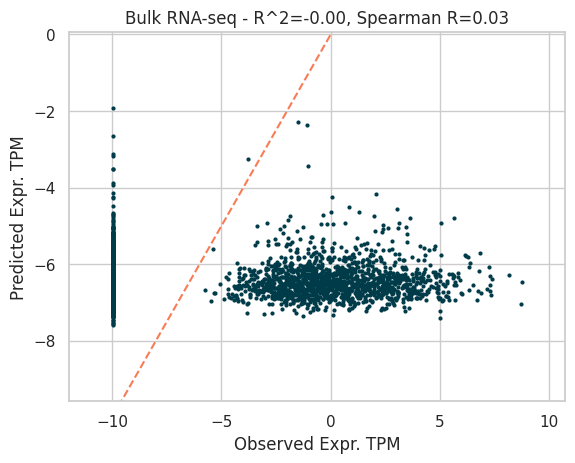

In [129]:
# plot_results(
#     y_test, 
#     y_pred, 
#     f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
# )

same data and preprocessing as above but running grid search again to seek better performance:

In [118]:
model, df_metrics, y_test, y_pred = run_regressor(
    X_train, X_test, y_train, y_test,
    hyperparameters=default_hyperparameters,
    random_state=0,
    find_optimal_parameters=True,
)  

Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6}


In [119]:
# df_metrics

mse      rmse      mae        r2  spearman
0  25.331433  5.033034  4.57154  0.001554  0.046293

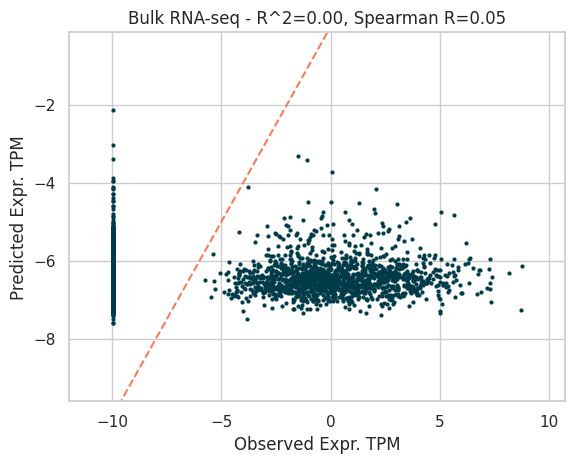

In [120]:
# plot_results(
#     y_test, 
#     y_pred, 
#     f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
# )

fixed tss==tes data issue, removed bases that are not covered.

In [57]:
# model, df_metrics, y_test, y_pred = run_regressor(
#     X_train, X_test, y_train, y_test,
#     hyperparameters=default_hyperparameters,
#     random_state=0,
#     find_optimal_parameters=False,
# )  

Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}


In [58]:
# df_metrics

mse      rmse       mae        r2  spearman
0  25.761524  5.075581  4.611537 -0.014045  0.048332

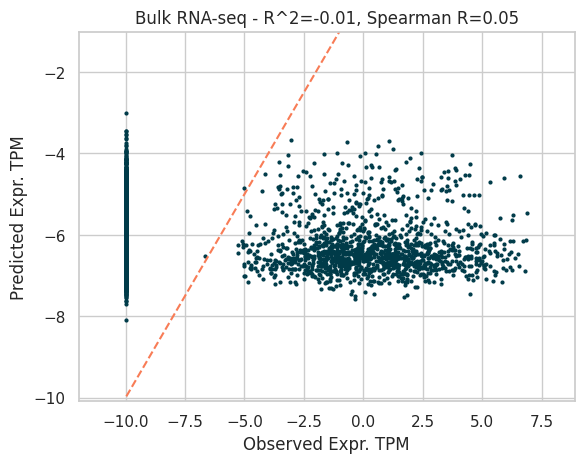

In [59]:
# plot_results(
#     y_test, 
#     y_pred, 
#     f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
# )

In [141]:
# model, df_metrics, y_test, y_pred = run_regressor(
#     X_train, X_test, y_train, y_test,
#     hyperparameters=default_hyperparameters,
#     random_state=0,
#     find_optimal_parameters=False,
# )  

Using params
{'n_estimators': 600, 'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7}


         mse      rmse       mae        r2  spearman
0  25.710925  5.070594  4.630395 -0.012054  0.063284


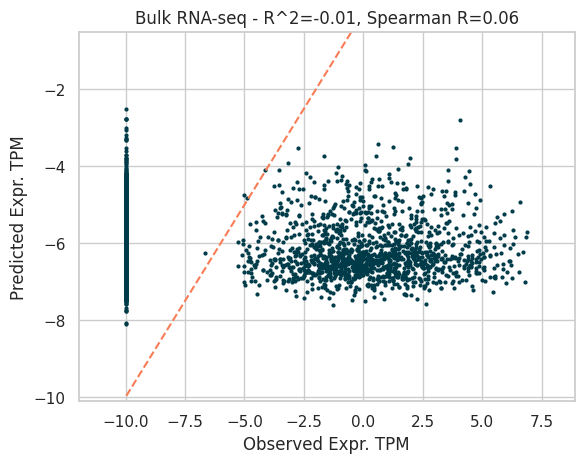

In [143]:
# print(df_metrics)
# plot_results(
#     y_test, 
#     y_pred, 
#     f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
# )

rkpm

Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}
         mse      rmse      mae        r2  spearman
0  50.345287  7.095441  6.11587 -0.004666  0.031405


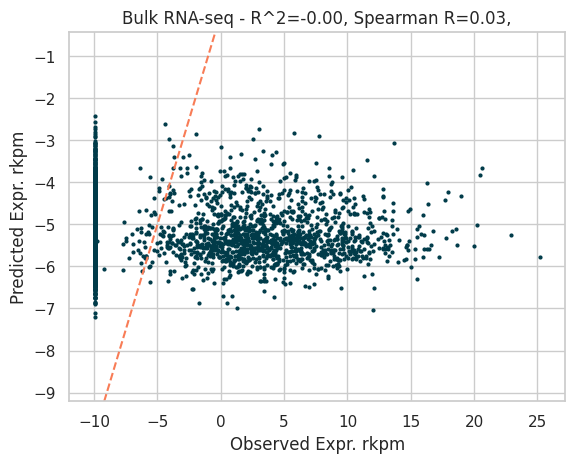

In [218]:
# model, df_metrics, y_test, y_pred = run_regressor(
#     X_train, X_test, y_train, y_test,
#     hyperparameters=default_hyperparameters,
#     random_state=0,
#     find_optimal_parameters=False,
# )  

# print(df_metrics)
# plot_results(
#     y_test, 
#     y_pred, 
#     f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f},", target
# )

Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}
         mse     rmse       mae        r2  spearman
0  49.660069  7.04699  6.092735 -0.010023  0.039338


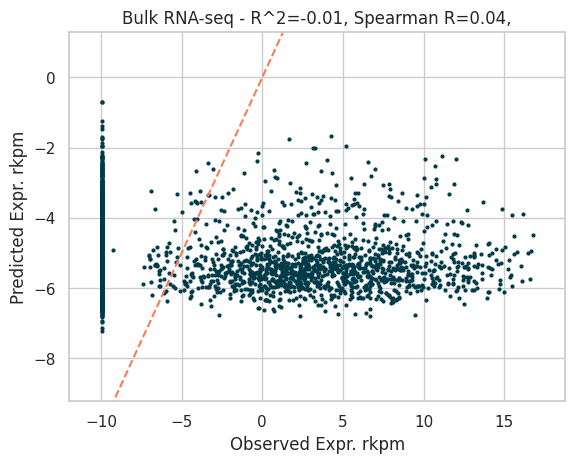

In [285]:
model, df_metrics, y_test, y_pred = run_regressor(
    X_train, X_test, y_train, y_test,
    hyperparameters=default_hyperparameters,
    random_state=0,
   find_optimal_parameters=False,
)  

print(df_metrics)
plot_results(
    y_test, 
    y_pred, 
    f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f},", target
)

Let's plot the predictions of the models versus the actual data on the held chromosome 8.

<!-- In the above model training, we set a pseudo-random state for reproducibility, but we need to ensure our accuracy estimates are robust to alternative starting random states. Below we train the data again with different pseudo-random states, to get an average value for r^2 and Spearman R. -->

In [301]:
df_regressor = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman"])
for k in range(0,20):
    model, df_metrics, _, _ = run_regressor(
        X_train, X_test, y_train, y_test,
        hyperparameters=default_hyperparameters,
        random_state=k,
        # test_contig=["8"],
        # missing_values_strategy="impute_mean",
        find_optimal_parameters=False,
    )
    df_regressor = pd.concat([df_regressor, df_metrics], ignore_index=True)
df_regressor = df_regressor.reset_index(drop=True)

Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}


Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}
Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}
Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}
Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}
Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}
Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}
Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8}
Using params
{'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth

<!-- The table below shows the average R^2 and Spearman coefficients of the model: -->

In [304]:
df_regressor[["r2", "spearman"]].describe()

r2   spearman
count  20.000000  20.000000
mean   -0.010887   0.038499
std     0.001894   0.003855
min    -0.014531   0.032120
25%    -0.012194   0.035824
50%    -0.010260   0.039239
75%    -0.009590   0.040692
max    -0.008040   0.046880

<!-- ## Binary Classifer -->

<!-- Depending on the biological question you are trying to answer, having a binary classifier may be more than sufficient and you may not need to train a regressor. We can also train such a classifier using [XGBoost](https://xgboost.readthedocs.io/en/stable/). The classifier can be binary (i.e. two categories: high expression and low expression), or have more categories (e.g., we could classify genes as having low expression, moderate expression, or high expression). Having more classes will likely result in a drop in the accuracy of the classifier (since it will have more opportunities to misclassify). -->

In [82]:
def train_classifier_model(X_train, y_train, hyperparameters, find_optimal_parameters, random_state=1):
    """
    Train an XGBoost classifier using the specified hyperparameters
    """
    classifier = xgb.XGBClassifier(
        random_state=random_state,
        **hyperparameters,
    )

  
    if find_optimal_parameters:
                best_params = tune_parameters(X_train, y_train, classifier, "roc_auc")
                hyperparameters.update(best_params)

    print("Using params")
    print(hyperparameters)

    classifier.fit(X_train, y_train)
    return classifier

In [61]:
def evaluate_classifier(model, X_test, y_test):
    """
    Evaluate the performance of the classifier using the test set
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # f1 score
    f1 = f1_score(y_test, y_pred, average="macro")

    # calculate AUC
    if len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:
        auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")

    return accuracy, f1, auc

In [62]:
def run_classifier_orig(
    data,
    features,
    mod,
    target,
    hyperparameters,
    random_state=1,
    missing_values_strategy="impute_mean",
    test_contig=None,
):
    """
    Run an xgboost classifier
    """

    features = select_features(features, mod)
    
    X_train, X_test, y_train, y_test = split_train_test_data(
        data, 
        features, 
        target, 
        test_contig,
        missing_values_strategy,
        )

    classifier = train_classifier_model(X_train, y_train, hyperparameters, random_state)

    accuracy, f1, auc = evaluate_classifier(classifier, X_test, y_test)

    df_metrics = pd.DataFrame(
        {
            "number_of_categories": [len(np.unique(y_train))],
            "accuracy": [accuracy],
            "macro_f1": [f1],
            "auc": [auc],

        }
    )

    return classifier, df_metrics

In [79]:
def run_classifier(
    X_train, X_test, y_train, y_test,
    hyperparameters,
    find_optimal_parameters,
    random_state=1,
):
    """
    Run an xgboost classifier
    """

    # features = select_features(features, mod)
    
    # X_train, X_test, y_train, y_test = split_train_test_data(
    #     data, 
    #     features, 
    #     target, 
    #     test_contig,
    #     missing_values_strategy,
    #     )

    classifier = train_classifier_model(X_train, y_train, hyperparameters, find_optimal_parameters, random_state)

    accuracy, f1, auc = evaluate_classifier(classifier, X_test, y_test)

    df_metrics = pd.DataFrame(
        {
            "number_of_categories": [len(np.unique(y_train))],
            "accuracy": [accuracy],
            "macro_f1": [f1],
            "auc": [auc],

        }
    )

    return classifier, df_metrics

<!-- Loop over the number of categories and evaluate the metrics of the classifier. -->

In [126]:
best_params= {'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6}

In [85]:
df_classifier = pd.DataFrame(columns=["number_of_categories", "accuracy", "macro_f1", "auc"])

number_of_categories = np.arange(2, 6, 1)
number_of_categories=[2]
for n in number_of_categories:

    # create n categories based on the response values
    labels = [k for k in range(n)]
    # df_features_expression["category"] = pd.cut(
    #     df_features_expression["Response"], bins=n, labels=labels
    # )
    y_train_binned = pd.cut(
        y_train, bins=n, labels=labels
    )
    y_test_binned = pd.cut(
        y_test, bins=n, labels=labels
    )
    
    # run the classifier
    c, df_metrics = run_classifier(
        X_train, X_test, y_train_binned, y_test_binned,
        # mod=["mc", "hmc"],
        hyperparameters=default_hyperparameters,
        find_optimal_parameters=True,
        random_state=1,
    )

    df_classifier = pd.concat([df_classifier, df_metrics], ignore_index=True)

Using params
{'n_estimators': 600, 'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7}


In [74]:
labels = [k for k in range(2)]
y_train_binned, bin_edges = pd.cut(
    y_train, bins=2, labels=labels, retbins=True
)
    
print("Bin edges:", bin_edges)


Bin edges: [-9.98291507 -1.40039188  7.16500053]


In [88]:
np.power(2, 7.16500053)


143.50931070836876

In [73]:
y_train.value_counts()

TPM
-9.965784    25049
-1.787558        5
-1.178816        4
-1.401113        4
-2.215841        4
             ...  
 1.874220        1
 3.689985        1
 3.557703        1
-1.188799        1
 5.277294        1
Name: count, Length: 12459, dtype: int64

In [89]:
# X_train

strand  mean_mc_before_tss_sense  mean_mc_after_tes_sense  \
0           0                 -9.965784                -0.448691   
1           0                 -9.965784                -0.448691   
2           0                 -9.209867                -0.541520   
3           0                 -9.209867                -0.541520   
4           0                 -8.396048                -0.319460   
...       ...                       ...                      ...   
42026       1                 -2.318384                -0.628425   
42028       1                 -2.318384                -0.354298   
42029       1                 -2.318384                -0.354298   
42030       1                 -0.261304                -0.567226   
42031       1                 -0.261304                -0.567226   

       mean_mc_genes_sense  mean_mc_first_exons_sense  \
0                -0.914935                  -9.408521   
1                -0.914935                  -9.408521   
2                -1.079197                  -9.965784   
3                -1.079197                  -9.965784   
4                -0.955367                  -9.026609   
...                    ...                        ...   
42026            -0.555360                  -2.257399   
42028            -0.541042                  -2.257399   
42029            -0.541042                  -2.257399   
42030            -0.382782                  -2.257399   
42031            -0.382782                  -2.257399   

       mean_mc_first_introns_sense  mean_mc_genes_antisense  \
0                        -8.569997                -0.914935   
1                        -8.569997                -0.914935   
2                        -1.100573                -1.079197   
3                        -1.100573                -1.079197   
4                        -1.786931                -0.955367   
...                            ...                      ...   
42026                    -0.555360                -0.555360   
42028                    -0.541042                -0.541042   
42029                    -0.541042                -0.541042   
42030                    -0.113915                -0.382782   
42031                    -0.113915                -0.382782   

       mean_mc_exons_sense  mean_mc_introns_sense  \
0                -0.495902              -0.843172   
1                -0.495902              -0.843172   
2                -0.340673              -1.058526   
3                -0.340673              -1.058526   
4                -0.350626              -0.543800   
...                    ...                    ...   
42026            -0.639007              -0.666751   
42028            -0.639007              -0.666751   
42029            -0.639007              -0.666751   
42030            -0.308552              -0.399756   
42031            -0.308552              -0.399756   

       mean_mc_five_prime_utrs_sense  ...  cpg_count_introns_sense  \
0                          -9.068302  ...                 0.040680   
1                          -9.068302  ...                 0.040680   
2                          -2.672289  ...                 0.283470   
3                          -2.672289  ...                 0.283470   
4                          -8.860057  ...                -0.252819   
...                              ...  ...                      ...   
42026                      -2.672289  ...                -0.113898   
42028                      -2.672289  ...                -0.113898   
42029                      -2.672289  ...                -0.113898   
42030                      -2.672289  ...                -0.451046   
42031                      -2.672289  ...                -0.451046   

       cpg_count_five_prime_utrs_sense  cpg_count_three_prime_utrs_sense  \
0                            -0.227561                         -0.305422   
1                            -0.227561                         -0.305422   
2                            -0.013890    

<Axes: xlabel='TPM', ylabel='Density'>

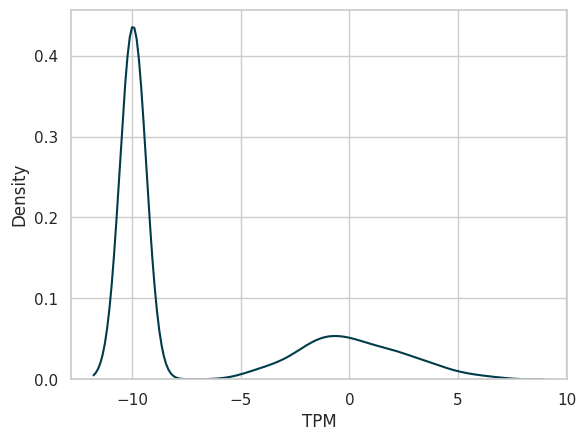

In [72]:
# sns.kdeplot(y_train)

<!-- A binary classifier achieves a good accuracy of 80% and AUC of 0.89. As the number of categories increase, the accuracy and F1 score decrease, since the classifier has more opportunities to misclassify. However, with three categories (i.e., low expression, moderate expression, or high expression) we still retain a robust accuracy of 89%. Note that we report the macro-F1 score, where the F1 score is calculated for each class independently, and the unweighted average of these scores is returned. -->


<!-- with all 0 peaked columns dropped -->

<!-- | number_of_categories | accuracy | macro_f1 | auc     |
|----------------------|----------|----------|---------|
| 2                    | 0.999305 | 0.499826 | 0.740625|
| 3                    | 0.999073 | 0.333179 | 0.729542|
| 4                    | 0.998841 | 0.249855 | 0.730702|
| 5                    | 0.997914 | 0.199791 | 0.570156| -->


<!-- using full set of columns applying log transform.

```
best_params= {'n_estimators': 600, 'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6}
```

| number_of_categories | accuracy | macro_f1 | auc     |
|----------------------|----------|----------|---------|
| 2                    | 0.801303 | 0.444846 | 0.536900|
| 3                    | 0.674500 | 0.268538 | 0.521427|
| 4                    | 0.662168 | 0.199188 | 0.511092|
| 5                    | 0.661005 | 0.159182 | 0.511270| -->


<!-- 'n_estimators': 600, 'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7
before_tss = after_tes problem fixed -->

In [86]:
# df_classifier

number_of_categories  accuracy  macro_f1       auc
0                    2  0.749583  0.428435  0.527604

<!-- ## Feature importance -->

<!-- ### XGboost feature importance -->

<!-- Let's look at the feature importance of our model, first using XGBoost's own `model.feature_importances_` functionality. -->

In [305]:
df_features_importance = pd.DataFrame(
    {
        "feature": select_features(features, ["mc", "hmc"]),
        "importance": model.feature_importances_,
    }
)

In [306]:
df_features_importance.sort_values("importance", ascending=False).head(10)

feature  importance
27             cpg_count_introns_sense    0.029079
9        mean_mc_five_prime_utrs_sense    0.028513
10      mean_mc_three_prime_utrs_sense    0.028477
34          range_length_introns_sense    0.028367
5          mean_mc_first_introns_sense    0.028308
26               cpg_count_exons_sense    0.028163
19      mean_hmc_five_prime_utrs_sense    0.028049
15        mean_hmc_first_introns_sense    0.027836
8                mean_mc_introns_sense    0.027825
35  range_length_five_prime_utrs_sense    0.027754

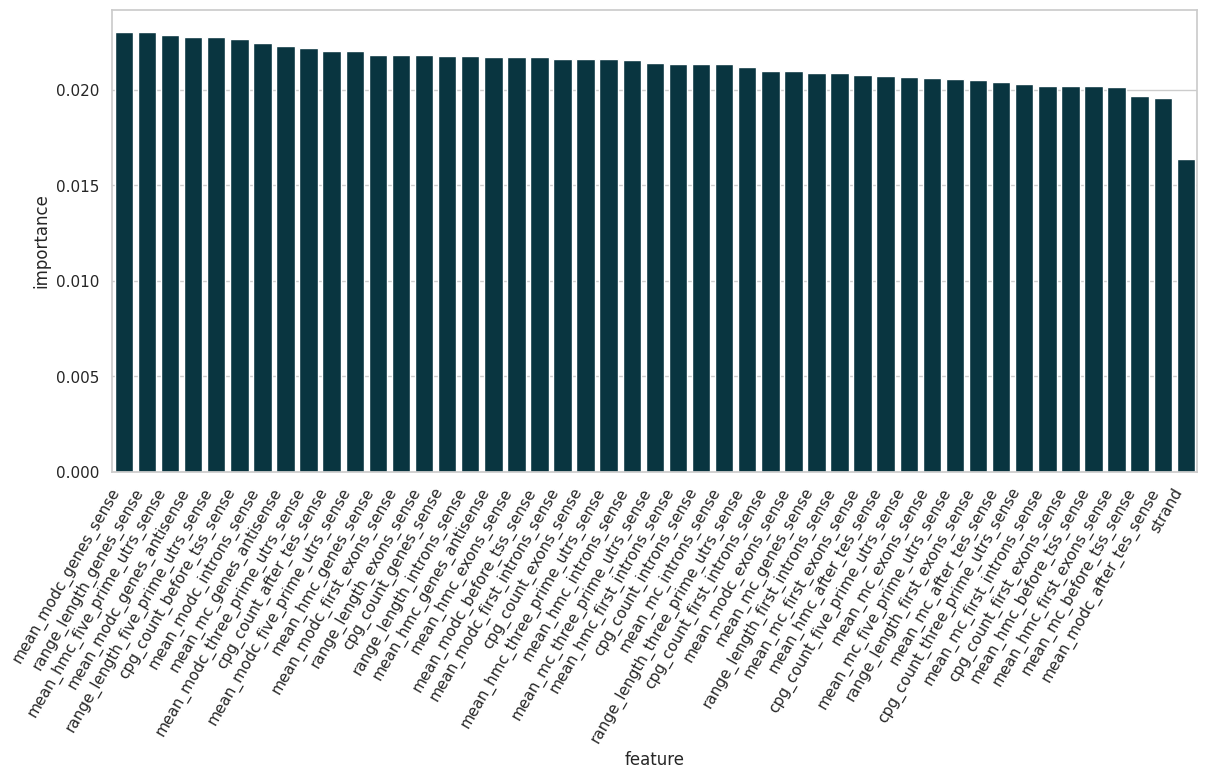

In [131]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(
    x="feature", 
    y="importance", 
    data=df_features_importance.sort_values("importance", ascending=False),
    )
plt.xticks(rotation=60, ha="right")
plt.show()

<!-- The length of the upstream, downstream, and around TSS regions are fixed by the user and therefore play little to no importance in the model.  -->


<!-- ### Region importance -->

<!-- Instead of looking at the importance of each feature individually, let's try to get some biological insights on which genomic regions bring the most contribution to the performance of the model. In order to do that, we run our regressor on each regions separately, and record their contributions to the R^2. -->

In [132]:
# column_order

['before_tss',
 'after_tes',
 'five_prime_utrs',
 'first_exons',
 'first_introns',
 'exons',
 'introns',
 'three_prime_utrs',
 'genes']

In [199]:
# sense = "sense"

In [137]:
# df_clean.columns

Index(['Gene_id', 'Chromosome', 'Start', 'End', 'Gene_name', 'strand',
       'mean_mc_before_tss_sense', 'mean_mc_after_tes_sense',
       'mean_mc_genes_sense', 'mean_mc_first_exons_sense',
       'mean_mc_first_introns_sense', 'mean_mc_genes_antisense',
       'mean_mc_exons_sense', 'mean_mc_introns_sense',
       'mean_mc_five_prime_utrs_sense', 'mean_mc_three_prime_utrs_sense',
       'mean_hmc_before_tss_sense', 'mean_hmc_after_tes_sense',
       'mean_hmc_genes_sense', 'mean_hmc_first_exons_sense',
       'mean_hmc_first_introns_sense', 'mean_hmc_genes_antisense',
       'mean_hmc_exons_sense', 'mean_hmc_introns_sense',
       'mean_hmc_five_prime_utrs_sense', 'mean_hmc_three_prime_utrs_sense',
       'mean_modc_before_tss_sense', 'mean_modc_after_tes_sense',
       'mean_modc_genes_sense', 'mean_modc_first_exons_sense',
       'mean_modc_first_introns_sense', 'mean_modc_genes_antisense',
       'mean_modc_exons_sense', 'mean_modc_introns_sense',
       'mean_modc_five_prime_utr

In [200]:
# N_runs = 10
# df_regressor = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman", "Region"])
# for region in column_order:
#     columns = [f"mean_mc_{region}_{sense}", f"mean_hmc_{region}_{sense}", f"cpg_count_{region}_{sense}", f"range_length_{region}_{sense}","strand"]
#     cols_found = [col for col in columns if col in df_clean.columns]
#     all_columns = cols_found + ["TPM", "Chromosome"]
#     df_one_region = df_clean[all_columns]
#     for k in range(0, N_runs):
#         X_train, X_test, y_train, y_test = preprocess(
#             data=df_one_region,
#             features=cols_found,
#             mod=["mc", "hmc"],
#             target=target,
#         )
#         _, df_metrics, _, _ = run_regressor(
#             X_train, X_test, y_train, y_test,
#             best_params

#         )
#         df_metrics["Region"] = region
#         df_regressor = pd.concat([df_regressor, df_metrics], ignore_index=True)

['mean_mc_before_tss_sense', 'mean_hmc_before_tss_sense', 'cpg_count_before_tss_sense', 'strand']
rows with 1.0 mc / hmC mean meth fration: 0
   mean_mc_before_tss_sense  mean_hmc_before_tss_sense  \
0                  0.000000                   0.000471   
1                  0.000000                   0.000471   
2                  0.000689                   0.001377   
3                  0.000689                   0.001377   
4                  0.001969                   0.000984   

   cpg_count_before_tss_sense  strand       TPM Chromosome  
0                        27.0       0  0.000000          1  
1                        27.0       0  0.000000          1  
2                        35.0       0  0.230208          1  
3                        35.0       0  0.196206          1  
4                        21.0       0  0.000000          1  
inside train test split
trainset: (37818, 6)
testset: (4211, 6)
TPM
0.000000     0.067311
0.305701     0.000048
0.163747     0.000048
1.410409 

NameError: name 'best_params' is not defined

<!-- Let's see if there are regions where hmC contributes significantly to the performance of the model. In order to visualise this, we repeat the experiment above, this time looking only at region importance for a model with mC but no hmC.  -->

In [197]:
# N_runs = 10
# df_regressor_mc_only = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman", "Region"])
# for region in column_order:
#     columns = [f"mean_mc_{region}_{sense}", f"cpg_count_{region}_{sense}", f"range_length_{region}_{sense}","strand"]
#     cols_found = [col for col in columns if col in df_clean.columns]
#     all_columns = cols_found + [target, "Chromosome"]
#     df_one_region = df_clean[all_columns]
#     for k in range(0, N_runs):
#         X_train, X_test, y_train, y_test = preprocess(
#             data=df_one_region,
#             features=cols_found,
#             mod=["mc"],
#             target=target,
#         )
#         _, df_metrics, _, _ = run_regressor(
#             X_train, X_test, y_train, y_test,
#             best_params

#         )
#         df_metrics["Region"] = region
#         df_regressor_mc_only = pd.concat([df_regressor_mc_only, df_metrics], ignore_index=True)

NameError: name 'sense' is not defined

In [ ]:
N_runs = 10
df_regressor_mc_only = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman", "Region"])
for region in column_order:
    columns = [f"mean_mc_{region}_{sense}", f"mean_hmc_{region}_{sense}", f"cpg_count_{region}_{sense}", f"range_length_{region}_{sense}"]
    all_columns = columns + ["Response", "Chromosome"]
    df_one_region = df_features_expression[all_columns]
    for k in range(0, N_runs):
        _, df_metrics, _, _ = run_regressor(
            data=df_one_region,
            features=columns,
            mod="mc",
            target="Response",
            hyperparameters=model_hyperparameters,
            random_state=k,
            test_contig=["8"],
            missing_values_strategy="impute_mean",
            find_optimal_parameters=False,
        )
        df_metrics["Region"] = region
        df_regressor_mc_only = pd.concat([df_regressor_mc_only, df_metrics], ignore_index=True)

<!-- Let's merge the two expereriments and plot the results. -->

In [145]:
# df_regressor_mc_only["features"] = "mc_only"
# df_regressor["features"] = "mc+hmc"
# df_regions = pd.concat([df_regressor, df_regressor_mc_only])

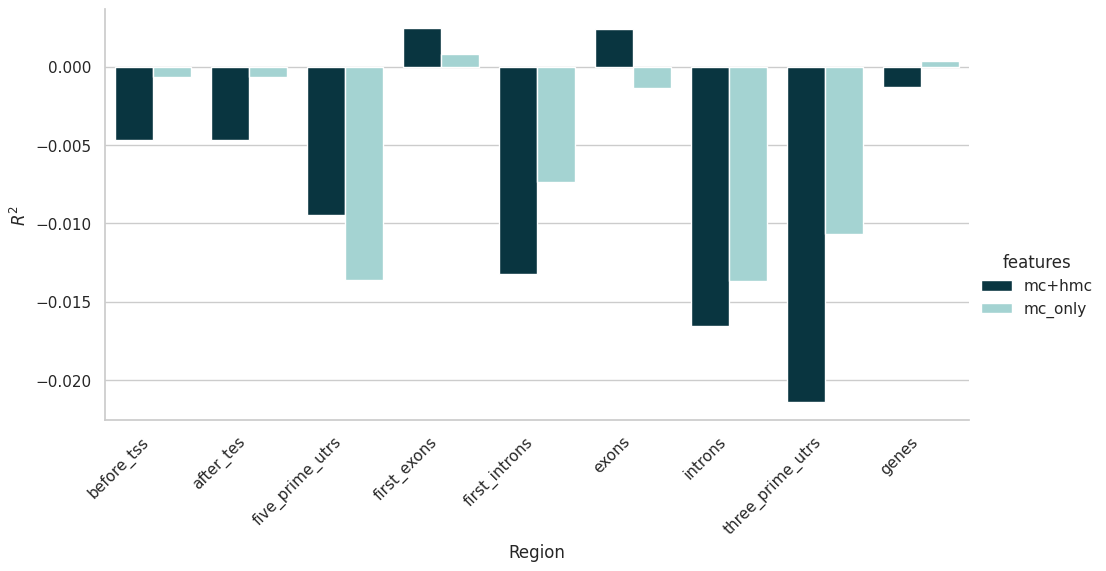

In [146]:
# sns.catplot(
#     data=df_regions,
#     x="Region",
#     y="r2",
#     hue="features",
#     kind="bar",
#     palette=biomodal_palette,
#     height=5,
#     aspect=2,
# )
# plt.xticks(rotation=45, ha="right")
# plt.ylabel(r"$R^2$")
# plt.show()

<!-- WIP... -->

<!-- In summary, this series of notebooks illustrates how `modality` can help constructing robust machine learning models. It achieves this by condensing methylation data across genomic ranges specified by external annotations, and efficiently grouping them together to generate feature sets, thereby facilitating the model-building process.

This notebook also highlights that the methylation signal obtained from evoC data contains sufficient information to make robust gene expression predictions. -->